# Phân tích và Dự đoán Nguy cơ Dry Eye Disease

## 1. Hiểu bài toán & dữ liệu

### Mô tả bài toán
Phân tích và dự đoán nguy cơ mắc **Dry Eye Disease (DED)** từ dữ liệu sức khỏe và hành vi sinh hoạt hàng ngày.

### Mục tiêu phân tích
1. Khám phá các yếu tố ảnh hưởng đến nguy cơ mắc DED
2. Phân tích mối liên hệ giữa thời gian sử dụng màn hình, chất lượng giấc ngủ và DED
3. Xây dựng mô hình dự đoán nguy cơ DED dựa trên các chỉ số sức khỏe
4. Đưa ra khuyến nghị về phòng ngừa DED

---
**Lưu ý:** Đây là mô hình ước lượng nguy cơ, không thay thế chẩn đoán y khoa.

### Import thư viện

In [12]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Thiết lập style hiển thị
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Tắt warning không cần thiết
import warnings
warnings.filterwarnings('ignore')

print("Đã import tất cả thư viện cần thiết")

Đã import tất cả thư viện cần thiết


In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Dry_Eye_Dataset.csv')

# Hiển thị 5 dòng đầu tiên
print("5 dòng đầu tiên của dataset:")
print(df.head())

# Kiểm tra kích thước dataset
print(f"\nKích thước dataset: {df.shape[0]} dòng, {df.shape[1]} cột")
# Hiển thị tên các cột
print(f"\nDanh sách các cột:")
print(df.columns.tolist())

5 dòng đầu tiên của dataset:
  Gender  Age  Sleep duration  Sleep quality  Stress level Blood pressure  Heart rate  Daily steps  Physical activity  Height  Weight Sleep disorder Wake up during night Feel sleepy during day Caffeine consumption Alcohol consumption Smoking Medical issue Ongoing medication Smart device before bed  Average screen time Blue-light filter Discomfort Eye-strain Redness in eye Itchiness/Irritation in eye Dry Eye Disease
0      F   24             9.5              2             1         137/89          67         3000                 31     161      69              Y                    N                      N                    N                   N       N             Y                  Y                       N                  8.7                 N                     Y              Y                           N               Y
1      M   39             9.6              2             3         108/64          60        12000                 74     164      87

### Load và khám phá dữ liệu

In [15]:
# Kiểm tra kiểu dữ liệu
print("Kiểu dữ liệu của các cột:")
print(df.dtypes)

print("\n" + "="*60)

# Kiểm tra thông tin tổng quan
print("\nThông tin tổng quan:")
df.info()

print("\n" + "="*60)

# Phát hiện các cột categorical
print("\nCác cột categorical (Y/N, Male/Female, etc.):")
for col in df.columns:
    unique_vals = df[col].unique()
    if len(unique_vals) <= 10:
        print(f"  • {col}: {unique_vals}")

print("\nGhi chú:")
print("  - Cần xử lý các cột Y/N → 1/0")
print("  - Cần encode Gender")
print("  - Cần tách Blood pressure thành systolic/diastolic")

Kiểu dữ liệu của các cột:
Gender                          object
Age                              int64
Sleep duration                 float64
Sleep quality                    int64
Stress level                     int64
Blood pressure                  object
Heart rate                       int64
Daily steps                      int64
Physical activity                int64
Height                           int64
Weight                           int64
Sleep disorder                  object
Wake up during night            object
Feel sleepy during day          object
Caffeine consumption            object
Alcohol consumption             object
Smoking                         object
Medical issue                   object
Ongoing medication              object
Smart device before bed         object
Average screen time            float64
Blue-light filter               object
Discomfort Eye-strain           object
Redness in eye                  object
Itchiness/Irritation in eye     object

### Data Cleaning & Preprocessing

In [16]:
# Data cleaning và preprocessing
df_clean = df.copy()

print("Bắt đầu data cleaning...")

# 1. Tách Blood pressure thành systolic và diastolic
if 'Blood pressure' in df_clean.columns:
    df_clean[['Systolic', 'Diastolic']] = df_clean['Blood pressure'].str.split('/', expand=True)
    df_clean['Systolic'] = pd.to_numeric(df_clean['Systolic'])
    df_clean['Diastolic'] = pd.to_numeric(df_clean['Diastolic'])
    df_clean = df_clean.drop('Blood pressure', axis=1)
    print("  Đã tách Blood pressure")

# 2. Chuyển Y/N thành 1/0
yn_columns = ['Sleep disorder', 'Wake up during night', 'Feel sleepy during day',
              'Caffeine consumption', 'Alcohol consumption', 'Smoking',
              'Medical issue', 'Ongoing medication', 'Smart device before bed',
              'Blue-light filter', 'Discomfort Eye-strain', 'Redness in eye',
              'Itchiness/Irritation in eye', 'Dry Eye Disease']
for col in yn_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map({'Y': 1, 'Yes': 1, 'N': 0, 'No': 0})
print(f"  Đã chuyển {len([c for c in yn_columns if c in df_clean.columns])} cột Y/N → 1/0")

# 3. Encode Gender
if 'Gender' in df_clean.columns:
    df_clean['Gender'] = df_clean['Gender'].map({'M': 1, 'Male': 1, 'F': 0, 'Female': 0})
    print("  Đã encode Gender (M/Male=1, F/Female=0)")

# 4. Kiểm tra missing values
print(f"\nKiểm tra missing values:")
missing = df_clean.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("Không có missing values")


print(f"\nData cleaning hoàn tất!")
print(f"Shape sau cleaning: {df_clean.shape}")
df_clean.head()

Bắt đầu data cleaning...
  Đã tách Blood pressure
  Đã chuyển 14 cột Y/N → 1/0
  Đã encode Gender (M/Male=1, F/Female=0)

Kiểm tra missing values:
Không có missing values

Data cleaning hoàn tất!
Shape sau cleaning: (20000, 27)


,Gender,Age,Sleep duration,Sleep quality,Stress level,Heart rate,Daily steps,Physical activity,Height,Weight,Sleep disorder,Wake up during night,Feel sleepy during day,Caffeine consumption,Alcohol consumption,Smoking,Medical issue,Ongoing medication,Smart device before bed,Average screen time,Blue-light filter,Discomfort Eye-strain,Redness in eye,Itchiness/Irritation in eye,Dry Eye Disease,Systolic,Diastolic
0,0,24,9.5,2,1,67,3000,31,161,69,1,0,0,0,0,0,1,1,0,8.7,0,1,1,0,1,137,89
1,1,39,9.6,2,3,60,12000,74,164,87,0,0,0,0,1,0,1,1,0,9.6,1,0,0,1,1,108,64
2,0,45,5.4,1,5,95,12000,93,179,94,1,1,0,1,1,0,0,0,1,4.0,0,1,0,0,0,134,81
3,0,45,5.4,4,5,78,19000,32,160,77,0,0,0,1,0,0,1,0,0,7.6,0,1,0,1,0,110,90
4,0,42,5.7,3,2,72,4000,173,179,99,0,1,0,0,0,0,1,0,0,3.5,0,1,1,0,1,99,67


## 2. EDA (Exploratory Data Analysis)

### Phân bố các biến quan trọng

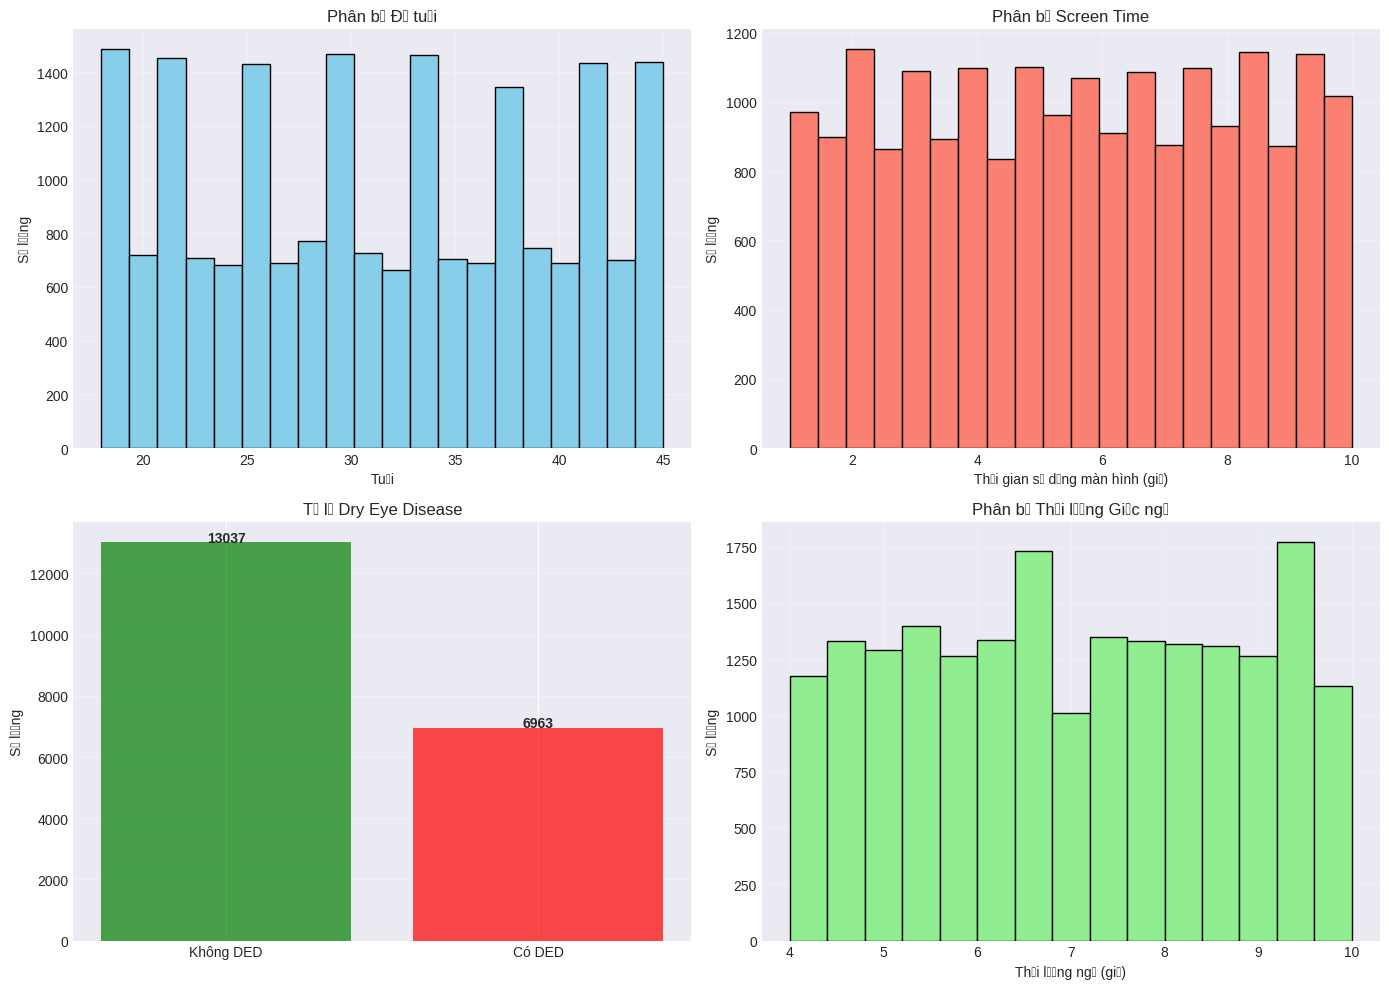

Tỷ lệ Dry Eye Disease:
  • Không DED: 6963 (34.8%)
  • Có DED: 13037 (65.2%)


In [17]:
# EDA cơ bản - Phân bố các biến quan trọng
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Phân bố Age
axes[0, 0].hist(df_clean['Age'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Tuổi')
axes[0, 0].set_ylabel('Số lượng')
axes[0, 0].set_title('Phân bố Độ tuổi')
axes[0, 0].grid(alpha=0.3)

# 2. Phân bố Screen time
axes[0, 1].hist(df_clean['Average screen time'], bins=20, color='salmon', edgecolor='black')
axes[0, 1].set_xlabel('Thời gian sử dụng màn hình (giờ)')
axes[0, 1].set_ylabel('Số lượng')
axes[0, 1].set_title('Phân bố Screen Time')
axes[0, 1].grid(alpha=0.3)

# 3. Tỷ lệ Dry Eye Disease
ded_counts = df_clean['Dry Eye Disease'].value_counts()
axes[1, 0].bar(['Không DED', 'Có DED'], ded_counts.values, color=['green', 'red'], alpha=0.7)
axes[1, 0].set_ylabel('Số lượng')
axes[1, 0].set_title('Tỷ lệ Dry Eye Disease')
axes[1, 0].grid(alpha=0.3, axis='y')
for i, v in enumerate(ded_counts.values):
    axes[1, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# 4. Phân bố Sleep duration
axes[1, 1].hist(df_clean['Sleep duration'], bins=15, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Thời lượng ngủ (giờ)')
axes[1, 1].set_ylabel('Số lượng')
axes[1, 1].set_title('Phân bố Thời lượng Giấc ngủ')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# In thống kê tỷ lệ DED
print(f"Tỷ lệ Dry Eye Disease:")
print(f"  • Không DED: {ded_counts[0]} ({ded_counts[0]/len(df_clean)*100:.1f}%)")
print(f"  • Có DED: {ded_counts[1]} ({ded_counts[1]/len(df_clean)*100:.1f}%)")

### Phân tích mối liên hệ với DED

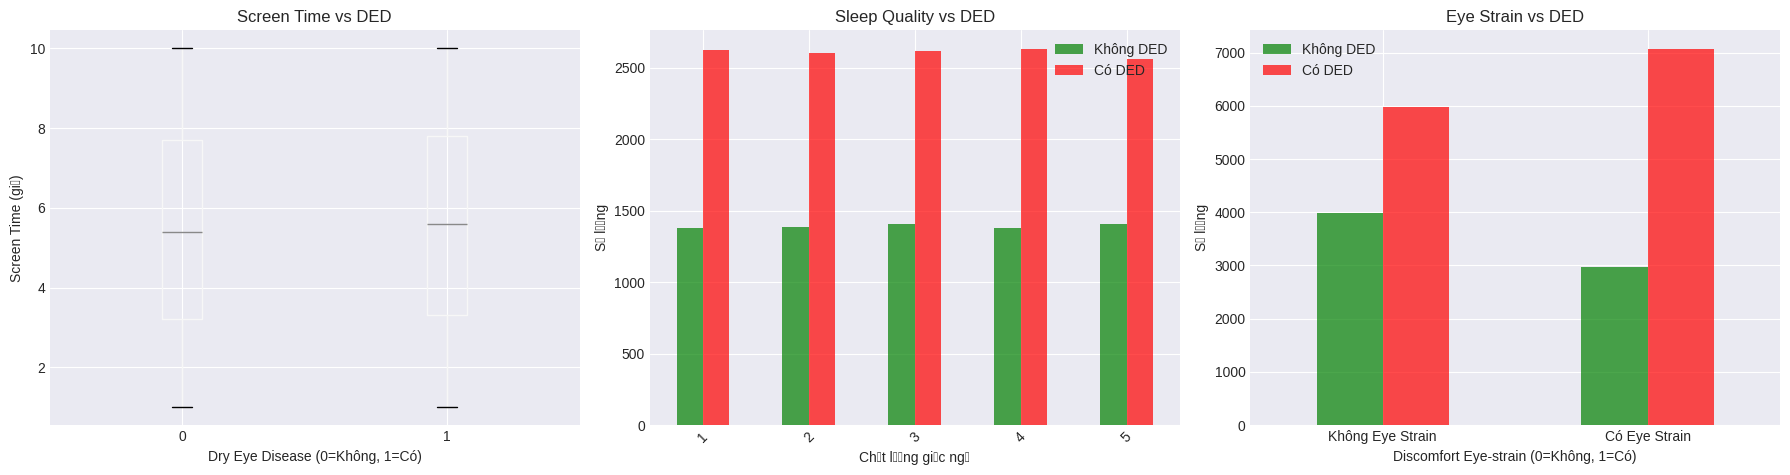

Thống kê mối liên hệ:

1. Screen time trung bình:
   Không DED: 5.44 giờ
   Có DED: 5.56 giờ

2. Tỷ lệ DED khi có Eye-strain:
   70.4% người có eye strain bị DED


In [18]:
# Phân tích mối liên hệ giữa các yếu tố và Dry Eye Disease
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Screen time vs Dry Eye Disease
df_clean.boxplot(column='Average screen time', by='Dry Eye Disease', ax=axes[0])
axes[0].set_xlabel('Dry Eye Disease (0=Không, 1=Có)')
axes[0].set_ylabel('Screen Time (giờ)')
axes[0].set_title('Screen Time vs DED')
axes[0].get_figure().suptitle('')

# 2. Sleep quality vs Dry Eye Disease
sleep_quality_ded = df_clean.groupby(['Sleep quality', 'Dry Eye Disease']).size().unstack(fill_value=0)
sleep_quality_ded.plot(kind='bar', ax=axes[1], color=['green', 'red'], alpha=0.7)
axes[1].set_xlabel('Chất lượng giấc ngủ')
axes[1].set_ylabel('Số lượng')
axes[1].set_title('Sleep Quality vs DED')
axes[1].legend(['Không DED', 'Có DED'])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

# 3. Discomfort Eye-strain vs Dry Eye Disease
eyestrain_ded = pd.crosstab(df_clean['Discomfort Eye-strain'], df_clean['Dry Eye Disease'])
eyestrain_ded.plot(kind='bar', ax=axes[2], color=['green', 'red'], alpha=0.7)
axes[2].set_xlabel('Discomfort Eye-strain (0=Không, 1=Có)')
axes[2].set_ylabel('Số lượng')
axes[2].set_title('Eye Strain vs DED')
axes[2].legend(['Không DED', 'Có DED'])
axes[2].set_xticklabels(['Không Eye Strain', 'Có Eye Strain'], rotation=0)

plt.tight_layout()
plt.show()

# Tính toán thống kê
print("Thống kê mối liên hệ:")
print(f"\n1. Screen time trung bình:")
print(f"   Không DED: {df_clean[df_clean['Dry Eye Disease']==0]['Average screen time'].mean():.2f} giờ")
print(f"   Có DED: {df_clean[df_clean['Dry Eye Disease']==1]['Average screen time'].mean():.2f} giờ")

print(f"\n2. Tỷ lệ DED khi có Eye-strain:")
eye_strain_yes = df_clean[df_clean['Discomfort Eye-strain']==1]
print(f"   {eye_strain_yes['Dry Eye Disease'].sum()/len(eye_strain_yes)*100:.1f}% người có eye strain bị DED")

## 3. Feature Engineering

*Phần này có thể thêm các feature mới nếu cần (ví dụ: BMI từ chiều cao/cân nặng, tương tác giữa các biến, ...)*

## 4. Feature Selection

### Chiến lược: Feature Importance-based Selection

1. Train model với **ALL features** trước
2. Phân tích **Feature Importance/Coefficients**
3. **Refine feature set** dựa trên features có signal thực sự
4. So sánh performance: All Features vs Refined Features

In [19]:
# Định nghĩa các tập features khác nhau để thử nghiệm
target = 'Dry Eye Disease'

# Loại bỏ các cột không phù hợp
drop_cols = [target]
if 'Person ID' in df_clean.columns:
    drop_cols.append('Person ID')

# Lấy all features
all_features = [col for col in df_clean.columns if col not in drop_cols]

print("Tất cả features có sẵn:")
print(all_features)
print(f"\nTổng số features: {len(all_features)}")

Tất cả features có sẵn:
['Gender', 'Age', 'Sleep duration', 'Sleep quality', 'Stress level', 'Heart rate', 'Daily steps', 'Physical activity', 'Height', 'Weight', 'Sleep disorder', 'Wake up during night', 'Feel sleepy during day', 'Caffeine consumption', 'Alcohol consumption', 'Smoking', 'Medical issue', 'Ongoing medication', 'Smart device before bed', 'Average screen time', 'Blue-light filter', 'Discomfort Eye-strain', 'Redness in eye', 'Itchiness/Irritation in eye', 'Systolic', 'Diastolic']

Tổng số features: 26


## 5. Data Split (Train / Test)

### Chia dữ liệu và chuẩn hóa với features đã chọn

### Bước 1: Train model với ALL features

BƯỚC 1: TRAIN MODEL VỚI ALL FEATURES

All Features (26 features):
   1. Gender
   2. Age
   3. Sleep duration
   4. Sleep quality
   5. Stress level
   6. Heart rate
   7. Daily steps
   8. Physical activity
   9. Height
  10. Weight
  11. Sleep disorder
  12. Wake up during night
  13. Feel sleepy during day
  14. Caffeine consumption
  15. Alcohol consumption
  16. Smoking
  17. Medical issue
  18. Ongoing medication
  19. Smart device before bed
  20. Average screen time
  21. Blue-light filter
  22. Discomfort Eye-strain
  23. Redness in eye
  24. Itchiness/Irritation in eye
  25. Systolic
  26. Diastolic

✓ Train set: 16000 samples
✓ Test set: 4000 samples
✓ After SMOTE: 20860 samples
✓ Class distribution: {0: 10430, 1: 10430}

----------------------------------------------------------------------
Training XGBoost với ALL features...
----------------------------------------------------------------------

KẾT QUẢ với ALL FEATURES:
  Accuracy:              0.7000
  Precision (DED): 

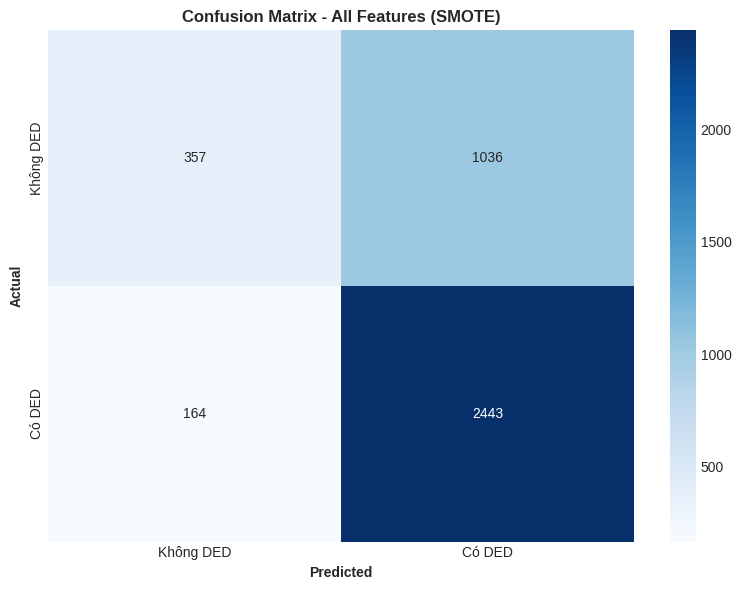

In [20]:
# Chuẩn bị data với ALL features
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import time

print("="*70)
print("BƯỚC 1: TRAIN MODEL VỚI ALL FEATURES")
print("="*70)

# Chuẩn bị X, y với all features
X_all = df_clean[all_features]
y_all = df_clean[target]

print(f"\nAll Features ({len(all_features)} features):")
for i, feat in enumerate(all_features, 1):
    print(f"  {i:2d}. {feat}")

# Split data
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

print(f"\n✓ Train set: {X_train_all.shape[0]} samples")
print(f"✓ Test set: {X_test_all.shape[0]} samples")

# Scaling
scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

# Apply SMOTE
sampler_all = SMOTE(random_state=42)
X_train_all_resampled, y_train_all_resampled = sampler_all.fit_resample(X_train_all_scaled, y_train_all)

print(f"✓ After SMOTE: {X_train_all_resampled.shape[0]} samples")
print(f"✓ Class distribution: {pd.Series(y_train_all_resampled).value_counts().to_dict()}")

# Train XGBoost với all features
print("\n" + "-"*70)
print("Training XGBoost với ALL features...")
print("-"*70)

start_time = time.time()
model_all_features = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
model_all_features.fit(X_train_all_resampled, y_train_all_resampled)

# Predict
y_pred_all = model_all_features.predict(X_test_all_scaled)

# Evaluate
accuracy_all = accuracy_score(y_test_all, y_pred_all)
report_all = classification_report(y_test_all, y_pred_all, output_dict=True, zero_division=0)
cv_scores_all = cross_val_score(model_all_features, X_train_all_resampled, y_train_all_resampled, cv=5, scoring='f1')
training_time_all = time.time() - start_time

print(f"\n{'='*70}")
print("KẾT QUẢ với ALL FEATURES:")
print(f"{'='*70}")
print(f"  Accuracy:              {accuracy_all:.4f}")
print(f"  Precision (DED):       {report_all['1']['precision']:.4f}")
print(f"  Recall (DED):          {report_all['1']['recall']:.4f}")
print(f"  F1-Score (DED):        {report_all['1']['f1-score']:.4f}")
print(f"  CV F1-Score:           {cv_scores_all.mean():.4f} (+/- {cv_scores_all.std():.4f})")
print(f"  Training Time:         {training_time_all:.2f}s")

# Confusion Matrix
cm_all = confusion_matrix(y_test_all, y_pred_all)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_all, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Không DED', 'Có DED'],
            yticklabels=['Không DED', 'Có DED'])
plt.title('Confusion Matrix - All Features (SMOTE)', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

### Bước 2: Phân tích Feature Importance

BƯỚC 2: PHÂN TÍCH FEATURE IMPORTANCE

FEATURE IMPORTANCE RANKING:
----------------------------------------------------------------------
Discomfort Eye-strain          0.1354 ██████
Itchiness/Irritation in eye    0.1329 ██████
Redness in eye                 0.1283 ██████
Stress level                   0.0994 ████
Smart device before bed        0.0734 ███
Sleep quality                  0.0545 ██
Gender                         0.0370 █
Alcohol consumption            0.0362 █
Smoking                        0.0325 █
Sleep disorder                 0.0296 █
Ongoing medication             0.0290 █
Caffeine consumption           0.0282 █
Feel sleepy during day         0.0243 █
Wake up during night           0.0238 █
Medical issue                  0.0226 █
Blue-light filter              0.0222 █
Daily steps                    0.0126 
Diastolic                      0.0109 
Age                            0.0104 
Average screen time            0.0093 
Systolic                       0.0090 
Physica

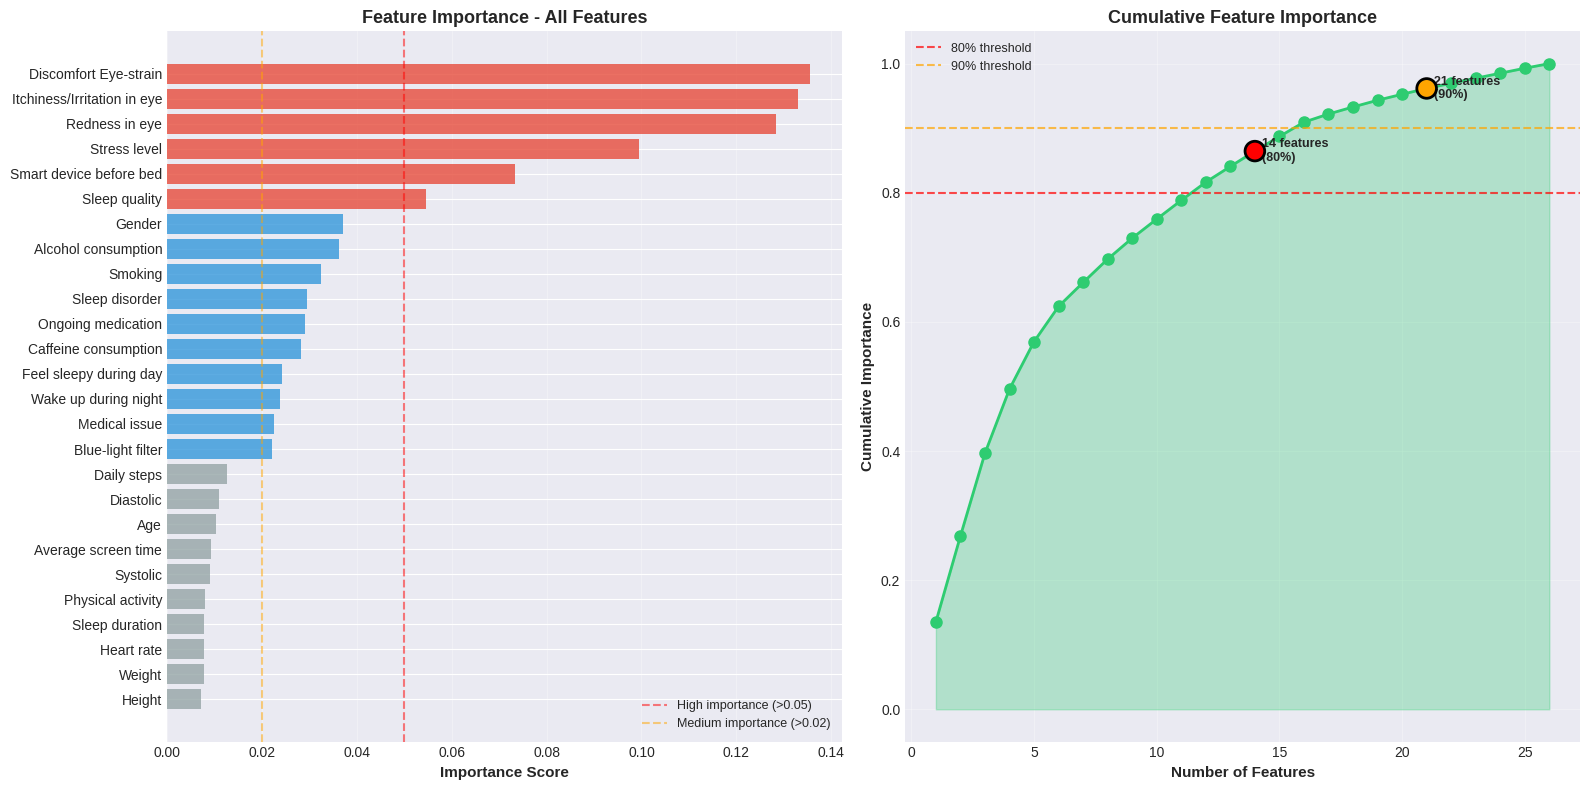


PHÂN TÍCH CHI TIẾT:

🔴 HIGH Importance (>0.05): 6 features
   • Discomfort Eye-strain          0.1354
   • Itchiness/Irritation in eye    0.1329
   • Redness in eye                 0.1283
   • Stress level                   0.0994
   • Smart device before bed        0.0734
   • Sleep quality                  0.0545

🟠 MEDIUM Importance (0.02-0.05): 10 features
   • Gender                         0.0370
   • Alcohol consumption            0.0362
   • Smoking                        0.0325
   • Sleep disorder                 0.0296
   • Ongoing medication             0.0290
   • Caffeine consumption           0.0282
   • Feel sleepy during day         0.0243
   • Wake up during night           0.0238
   • Medical issue                  0.0226
   • Blue-light filter              0.0222

⚪ LOW Importance (<0.02): 10 features
   • Daily steps                    0.0126
   • Diastolic                      0.0109
   • Age                            0.0104
   • Average screen time            0.

In [21]:
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': model_all_features.feature_importances_
}).sort_values('Importance', ascending=False)

print("="*70)
print("BƯỚC 2: PHÂN TÍCH FEATURE IMPORTANCE")
print("="*70)

print(f"\nFEATURE IMPORTANCE RANKING:")
print("-"*70)
for idx, row in feature_importance_df.iterrows():
    bar_length = int(row['Importance'] * 50)
    bar = '█' * bar_length
    print(f"{row['Feature']:30s} {row['Importance']:.4f} {bar}")

# Visualize Feature Importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 1. Bar chart tất cả features
ax1 = axes[0]
colors = ['#e74c3c' if imp > 0.05 else '#3498db' if imp > 0.02 else '#95a5a6'
          for imp in feature_importance_df['Importance']]
ax1.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], color=colors, alpha=0.8)
ax1.set_yticks(range(len(feature_importance_df)))
ax1.set_yticklabels(feature_importance_df['Feature'])
ax1.set_xlabel('Importance Score', fontweight='bold', fontsize=11)
ax1.set_title('Feature Importance - All Features', fontweight='bold', fontsize=13)
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(x=0.05, color='red', linestyle='--', alpha=0.5, label='High importance (>0.05)')
ax1.axvline(x=0.02, color='orange', linestyle='--', alpha=0.5, label='Medium importance (>0.02)')
ax1.legend(fontsize=9)

# 2. Cumulative importance
ax2 = axes[1]
cumsum = feature_importance_df['Importance'].cumsum()
ax2.plot(range(1, len(cumsum)+1), cumsum, 'o-', linewidth=2, markersize=8, color='#2ecc71')
ax2.fill_between(range(1, len(cumsum)+1), cumsum, alpha=0.3, color='#2ecc71')
ax2.axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% threshold')
ax2.axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_xlabel('Number of Features', fontweight='bold', fontsize=11)
ax2.set_ylabel('Cumulative Importance', fontweight='bold', fontsize=11)
ax2.set_title('Cumulative Feature Importance', fontweight='bold', fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=9)

# Đánh dấu điểm 80% và 90%
n_features_80 = (cumsum >= 0.8).idxmax() + 1
n_features_90 = (cumsum >= 0.9).idxmax() + 1
ax2.scatter([n_features_80, n_features_90], [cumsum.iloc[n_features_80-1], cumsum.iloc[n_features_90-1]],
           s=200, c=['red', 'orange'], zorder=5, edgecolors='black', linewidths=2)
ax2.text(n_features_80, cumsum.iloc[n_features_80-1], f'  {n_features_80} features\n  (80%)',
        fontweight='bold', fontsize=9, va='center')
ax2.text(n_features_90, cumsum.iloc[n_features_90-1], f'  {n_features_90} features\n  (90%)',
        fontweight='bold', fontsize=9, va='center')

plt.tight_layout()
plt.show()

# Phân tích chi tiết
print(f"\n{'='*70}")
print("PHÂN TÍCH CHI TIẾT:")
print(f"{'='*70}")

high_importance = feature_importance_df[feature_importance_df['Importance'] > 0.05]
medium_importance = feature_importance_df[(feature_importance_df['Importance'] > 0.02) & (feature_importance_df['Importance'] <= 0.05)]
low_importance = feature_importance_df[feature_importance_df['Importance'] <= 0.02]

print(f"\n🔴 HIGH Importance (>0.05): {len(high_importance)} features")
if len(high_importance) > 0:
    for idx, row in high_importance.iterrows():
        print(f"   • {row['Feature']:30s} {row['Importance']:.4f}")

print(f"\n🟠 MEDIUM Importance (0.02-0.05): {len(medium_importance)} features")
if len(medium_importance) > 0:
    for idx, row in medium_importance.iterrows():
        print(f"   • {row['Feature']:30s} {row['Importance']:.4f}")

print(f"\n⚪ LOW Importance (<0.02): {len(low_importance)} features")
if len(low_importance) > 0:
    for idx, row in low_importance.iterrows():
        print(f"   • {row['Feature']:30s} {row['Importance']:.4f}")

print(f"\n💡 Để đạt 80% total importance cần: {n_features_80} features")
print(f"💡 Để đạt 90% total importance cần: {n_features_90} features")

### Bước 3: Refine Feature Set dựa trên Importance

BƯỚC 3: REFINE FEATURE SET

Chiến lược:
  1. Chọn features đạt 90% cumulative importance: 21 features
  2. Loại bỏ features y tế khó thu thập: Systolic, Diastolic, Heart rate
  3. Tổng features cuối cùng: 19 features

📌 Selected Features (19 features):
   1. Discomfort Eye-strain          (importance: 0.1354, cumulative: 0.9696)
   2. Itchiness/Irritation in eye    (importance: 0.1329, cumulative: 0.9851)
   3. Redness in eye                 (importance: 0.1283, cumulative: 0.9774)
   4. Stress level                   (importance: 0.0994, cumulative: 0.5695)
   5. Smart device before bed        (importance: 0.0734, cumulative: 0.9433)
   6. Sleep quality                  (importance: 0.0545, cumulative: 0.4961)
   7. Gender                         (importance: 0.0370, cumulative: 0.1354)
   8. Alcohol consumption            (importance: 0.0362, cumulative: 0.8872)
   9. Smoking                        (importance: 0.0325, cumulative: 0.9093)
  10. Sleep disorder                 (importa

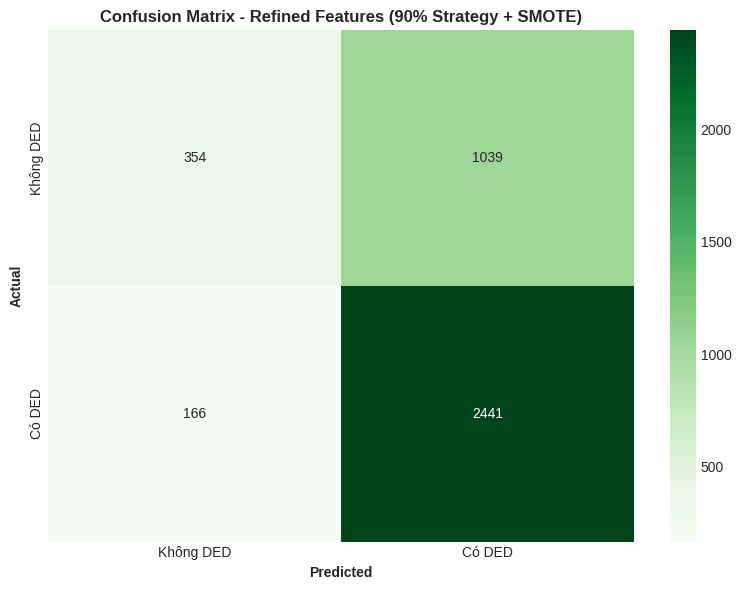

In [22]:
# Tạo refined feature set - Chiến lược: 90% cumulative importance + loại bỏ features y tế khó thu thập

# Tính cumulative importance
cumsum = feature_importance_df['Importance'].cumsum()

# Tìm số features cần để đạt 90% cumulative importance
n_features_90 = (cumsum >= 0.9).idxmax() + 1

# Lấy top features đạt 90% importance
top_90_features = feature_importance_df.head(n_features_90)['Feature'].tolist()

# Loại bỏ các features y tế khó thu thập
medical_features_to_remove = ['Systolic', 'Diastolic', 'Heart rate']
refined_features = [f for f in top_90_features if f not in medical_features_to_remove]

print("="*70)
print(f"BƯỚC 3: REFINE FEATURE SET")
print("="*70)
print(f"\nChiến lược:")
print(f"  1. Chọn features đạt 90% cumulative importance: {n_features_90} features")
print(f"  2. Loại bỏ features y tế khó thu thập: {', '.join(medical_features_to_remove)}")
print(f"  3. Tổng features cuối cùng: {len(refined_features)} features")

print(f"\n📌 Selected Features ({len(refined_features)} features):")
for i, feat in enumerate(refined_features, 1):
    imp = feature_importance_df[feature_importance_df['Feature'] == feat]['Importance'].values[0]
    # Tính cumulative importance của feature này
    feat_idx = feature_importance_df[feature_importance_df['Feature'] == feat].index[0]
    cum_imp = cumsum.iloc[feat_idx]
    print(f"  {i:2d}. {feat:30s} (importance: {imp:.4f}, cumulative: {cum_imp:.4f})")

print(f"\n❌ Removed Features:")
# Features bị loại bỏ vì nằm ngoài 90%
low_importance_features = [f for f in all_features if f not in top_90_features]
# Features bị loại bỏ vì là medical features
removed_medical = [f for f in top_90_features if f in medical_features_to_remove]

if removed_medical:
    print(f"\n  🏥 Loại bỏ do khó thu thập ({len(removed_medical)} features):")
    for i, feat in enumerate(removed_medical, 1):
        imp = feature_importance_df[feature_importance_df['Feature'] == feat]['Importance'].values[0]
        print(f"    {i}. {feat:30s} (importance: {imp:.4f})")

if low_importance_features:
    print(f"\n  📉 Loại bỏ do importance thấp ({len(low_importance_features)} features):")
    for i, feat in enumerate(low_importance_features, 1):
        imp = feature_importance_df[feature_importance_df['Feature'] == feat]['Importance'].values[0]
        print(f"    {i}. {feat:30s} (importance: {imp:.4f})")

# Train model với refined features
print("\n" + "-"*70)
print("Training XGBoost với REFINED features...")
print("-"*70)

# Chuẩn bị data
X_refined = df_clean[refined_features]
y_refined = df_clean[target]

X_train_refined, X_test_refined, y_train_refined, y_test_refined = train_test_split(
    X_refined, y_refined, test_size=0.2, random_state=42, stratify=y_refined
)

# Scaling
scaler_refined = StandardScaler()
X_train_refined_scaled = scaler_refined.fit_transform(X_train_refined)
X_test_refined_scaled = scaler_refined.transform(X_test_refined)

# SMOTE
sampler_refined = SMOTE(random_state=42)
X_train_refined_resampled, y_train_refined_resampled = sampler_refined.fit_resample(
    X_train_refined_scaled, y_train_refined
)

# Train
start_time = time.time()
model_refined = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
model_refined.fit(X_train_refined_resampled, y_train_refined_resampled)

# Predict & Evaluate
y_pred_refined = model_refined.predict(X_test_refined_scaled)
accuracy_refined = accuracy_score(y_test_refined, y_pred_refined)
report_refined = classification_report(y_test_refined, y_pred_refined, output_dict=True, zero_division=0)
cv_scores_refined = cross_val_score(model_refined, X_train_refined_resampled, y_train_refined_resampled,
                                   cv=5, scoring='f1')
training_time_refined = time.time() - start_time

print(f"\n{'='*70}")
print("KẾT QUẢ với REFINED FEATURES:")
print(f"{'='*70}")
print(f"  Accuracy:              {accuracy_refined:.4f}")
print(f"  Precision (DED):       {report_refined['1']['precision']:.4f}")
print(f"  Recall (DED):          {report_refined['1']['recall']:.4f}")
print(f"  F1-Score (DED):        {report_refined['1']['f1-score']:.4f}")
print(f"  CV F1-Score:           {cv_scores_refined.mean():.4f} (+/- {cv_scores_refined.std():.4f})")
print(f"  Training Time:         {training_time_refined:.2f}s")

# Confusion Matrix
cm_refined = confusion_matrix(y_test_refined, y_pred_refined)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_refined, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Không DED', 'Có DED'],
            yticklabels=['Không DED', 'Có DED'])
plt.title('Confusion Matrix - Refined Features (90% Strategy + SMOTE)', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

### Bước 4 (Tuỳ chọn): So sánh ALL vs REFINED Features

Có thể chạy cell dưới để so sánh kết quả giữa All Features và Refined Features

## 7. Hyperparameter Tuning cho XGBoost

### GridSearchCV để tìm hyperparameters tốt nhất với Refined Features + SMOTE

### Thực hiện GridSearchCV

In [12]:
# GridSearchCV để tìm hyperparameters tốt nhất cho XGBoost
from sklearn.model_selection import GridSearchCV

# Sử dụng refined features + SMOTE từ Bước 3
print("="*70)
print("HYPERPARAMETER TUNING - XGBOOST với REFINED FEATURES + SMOTE")
print("="*70)

# Định nghĩa param grid để tìm kiếm
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2]
}


# Khởi tạo XGBoost base model
xgb_base = XGBClassifier(random_state=42, eval_metric='logloss')

# GridSearchCV với cross-validation
print("\nBắt đầu GridSearchCV...")
print("Lưu ý: Quá trình này có thể mất vài phút...")
print("="*70)

grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=param_grid,
    scoring='f1',  # Tối ưu F1-score cho class positive (DED)
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV với refined features + SMOTE
start_time = time.time()
grid_search.fit(X_train_refined_resampled, y_train_refined_resampled)
training_time = time.time() - start_time

print("\n" + "="*70)
print(f"GridSearchCV hoàn tất trong {training_time:.2f}s")
print("="*70)

# In best parameters
print("\n🏆 Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\n🎯 Best CV F1-Score: {grid_search.best_score_:.4f}")

# Lưu best parameters vào file JSON
import json

best_params_with_score = {
    'best_parameters': grid_search.best_params_,
    'best_cv_f1_score': float(grid_search.best_score_),
    'training_time_seconds': float(training_time),
    'n_features': len(refined_features),
    'features_used': refined_features,
    'imbalance_method': 'SMOTE',
    'timestamp': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('best_xgboost_params.json', 'w', encoding='utf-8') as f:
    json.dump(best_params_with_score, f, indent=4, ensure_ascii=False)

print(f"\n✓ Đã lưu best parameters vào file: best_xgboost_params.json")

HYPERPARAMETER TUNING - XGBOOST với REFINED FEATURES + SMOTE

Bắt đầu GridSearchCV...
Lưu ý: Quá trình này có thể mất vài phút...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

GridSearchCV hoàn tất trong 4526.68s

🏆 Best Parameters:
  colsample_bytree: 0.9
  gamma: 0
  learning_rate: 0.1
  max_depth: 3
  min_child_weight: 1
  n_estimators: 150
  subsample: 0.8

🎯 Best CV F1-Score: 0.8184

✓ Đã lưu best parameters vào file: best_xgboost_params.json


### Đánh giá Model sau Hyperparameter Tuning

KẾT QUẢ XGBoost SAU KHI HYPERPARAMETER TUNING

Accuracy: 0.7003 (70.03%)

Classification Report:
              precision    recall  f1-score   support

   Không DED       0.69      0.25      0.37      1393
      Có DED       0.70      0.94      0.80      2607

    accuracy                           0.70      4000
   macro avg       0.70      0.60      0.59      4000
weighted avg       0.70      0.70      0.65      4000


Confusion Matrix:
[[ 355 1038]
 [ 161 2446]]


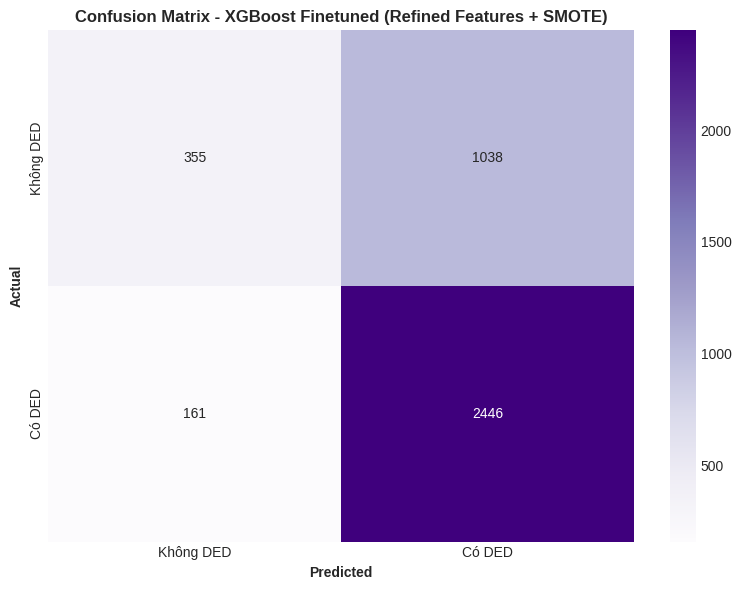


Các chỉ số quan trọng (Class DED):
  Precision: 0.7021
  Recall: 0.9382
  F1-Score: 0.8032


In [13]:
# Đánh giá model đã finetune
best_xgb_model = grid_search.best_estimator_

# Dự đoán trên test set với refined features
y_pred_tuned = best_xgb_model.predict(X_test_refined_scaled)

# Đánh giá
print("="*70)
print("KẾT QUẢ XGBoost SAU KHI HYPERPARAMETER TUNING")
print("="*70)

accuracy_tuned = accuracy_score(y_test_refined, y_pred_tuned)
print(f"\nAccuracy: {accuracy_tuned:.4f} ({accuracy_tuned*100:.2f}%)")

report_tuned = classification_report(y_test_refined, y_pred_tuned, target_names=['Không DED', 'Có DED'])
print("\nClassification Report:")
print(report_tuned)

# Confusion Matrix
cm_tuned = confusion_matrix(y_test_refined, y_pred_tuned)
print("\nConfusion Matrix:")
print(cm_tuned)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Không DED', 'Có DED'],
            yticklabels=['Không DED', 'Có DED'])
plt.title('Confusion Matrix - XGBoost Finetuned (Refined Features + SMOTE)', fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# Lưu kết quả để so sánh
report_dict_tuned = classification_report(y_test_refined, y_pred_tuned, output_dict=True, zero_division=0)
precision_tuned = report_dict_tuned['1']['precision']
recall_tuned = report_dict_tuned['1']['recall']
f1_tuned = report_dict_tuned['1']['f1-score']

print(f"\nCác chỉ số quan trọng (Class DED):")
print(f"  Precision: {precision_tuned:.4f}")
print(f"  Recall: {recall_tuned:.4f}")
print(f"  F1-Score: {f1_tuned:.4f}")

### So sánh Baseline vs Finetuned Model

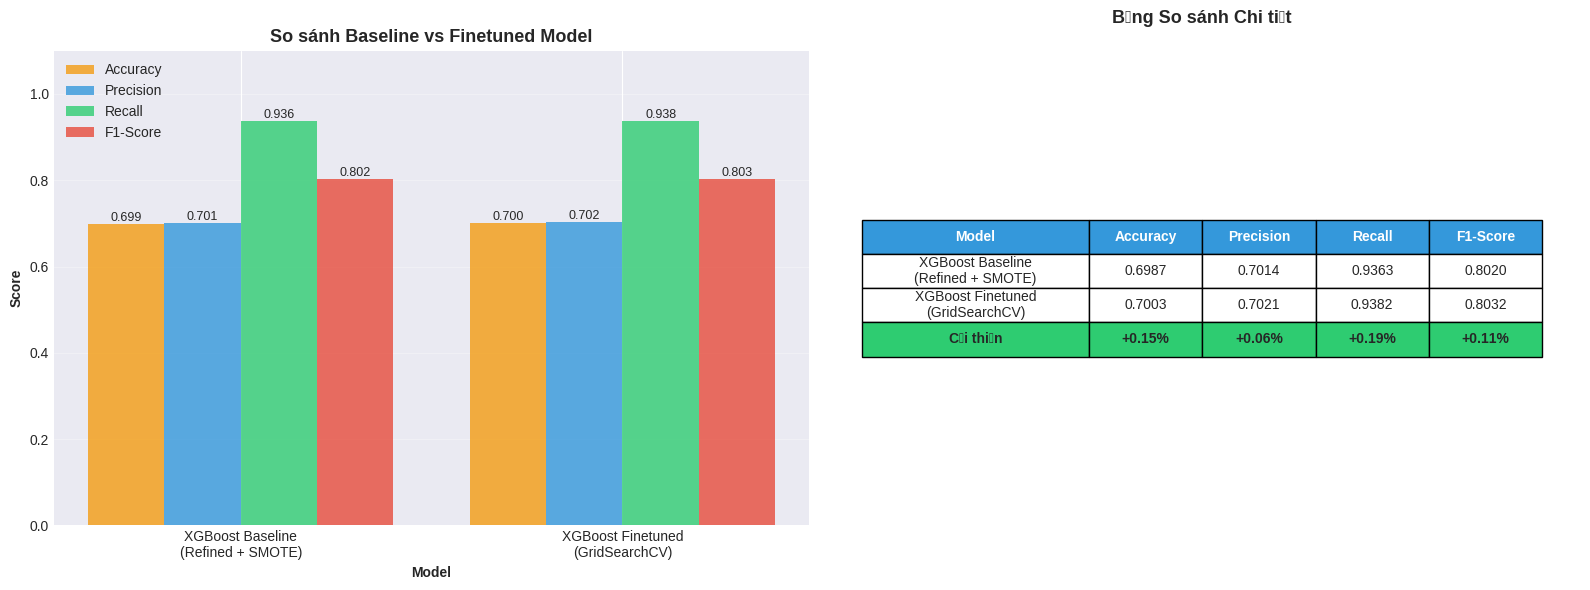


TỔNG KẾT SO SÁNH:

Baseline Model (Refined Features + SMOTE):
  Accuracy:  0.6987
  F1-Score:  0.8020

Finetuned Model (GridSearchCV):
  Accuracy:  0.7003
  F1-Score:  0.8032

Cải thiện:
  Accuracy:  +0.15%
  F1-Score:  +0.11%


In [14]:
# So sánh model trước và sau hyperparameter tuning
comparison_data = {
    'Model': ['XGBoost Baseline\n(Refined + SMOTE)', 'XGBoost Finetuned\n(GridSearchCV)'],
    'Accuracy': [accuracy_refined, accuracy_tuned],
    'Precision': [report_refined['1']['precision'], precision_tuned],
    'Recall': [report_refined['1']['recall'], recall_tuned],
    'F1-Score': [report_refined['1']['f1-score'], f1_tuned]
}

comparison_df = pd.DataFrame(comparison_data)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Bar chart comparison
x_pos = np.arange(len(comparison_df['Model']))
width = 0.2

bars1 = axes[0].bar(x_pos - 1.5*width, comparison_df['Accuracy'], width, label='Accuracy', color='#f39c12', alpha=0.8)
bars2 = axes[0].bar(x_pos - 0.5*width, comparison_df['Precision'], width, label='Precision', color='#3498db', alpha=0.8)
bars3 = axes[0].bar(x_pos + 0.5*width, comparison_df['Recall'], width, label='Recall', color='#2ecc71', alpha=0.8)
bars4 = axes[0].bar(x_pos + 1.5*width, comparison_df['F1-Score'], width, label='F1-Score', color='#e74c3c', alpha=0.8)

axes[0].set_xlabel('Model', fontweight='bold')
axes[0].set_ylabel('Score', fontweight='bold')
axes[0].set_title('So sánh Baseline vs Finetuned Model', fontweight='bold', fontsize=13)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(comparison_df['Model'])
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Thêm giá trị
for bars in [bars1, bars2, bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. Table comparison
axes[1].axis('tight')
axes[1].axis('off')

table_data = []
for idx, row in comparison_df.iterrows():
    table_data.append([
        row['Model'],
        f"{row['Accuracy']:.4f}",
        f"{row['Precision']:.4f}",
        f"{row['Recall']:.4f}",
        f"{row['F1-Score']:.4f}"
    ])

# Calculate improvement
improvement = [
    'Cải thiện',
    f"+{(comparison_df.iloc[1]['Accuracy'] - comparison_df.iloc[0]['Accuracy'])*100:.2f}%",
    f"+{(comparison_df.iloc[1]['Precision'] - comparison_df.iloc[0]['Precision'])*100:.2f}%",
    f"+{(comparison_df.iloc[1]['Recall'] - comparison_df.iloc[0]['Recall'])*100:.2f}%",
    f"+{(comparison_df.iloc[1]['F1-Score'] - comparison_df.iloc[0]['F1-Score'])*100:.2f}%"
]
table_data.append(improvement)

table = axes[1].table(cellText=table_data,
                     colLabels=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.3, 0.15, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(5):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style improvement row
for i in range(5):
    table[(3, i)].set_facecolor('#2ecc71')
    table[(3, i)].set_text_props(weight='bold')

axes[1].set_title('Bảng So sánh Chi tiết', fontweight='bold', fontsize=13, pad=20)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("TỔNG KẾT SO SÁNH:")
print("="*70)
print(f"\nBaseline Model (Refined Features + SMOTE):")
print(f"  Accuracy:  {accuracy_refined:.4f}")
print(f"  F1-Score:  {report_refined['1']['f1-score']:.4f}")

print(f"\nFinetuned Model (GridSearchCV):")
print(f"  Accuracy:  {accuracy_tuned:.4f}")
print(f"  F1-Score:  {f1_tuned:.4f}")

print(f"\nCải thiện:")
print(f"  Accuracy:  +{(accuracy_tuned - accuracy_refined)*100:.2f}%")
print(f"  F1-Score:  +{(f1_tuned - report_refined['1']['f1-score'])*100:.2f}%")

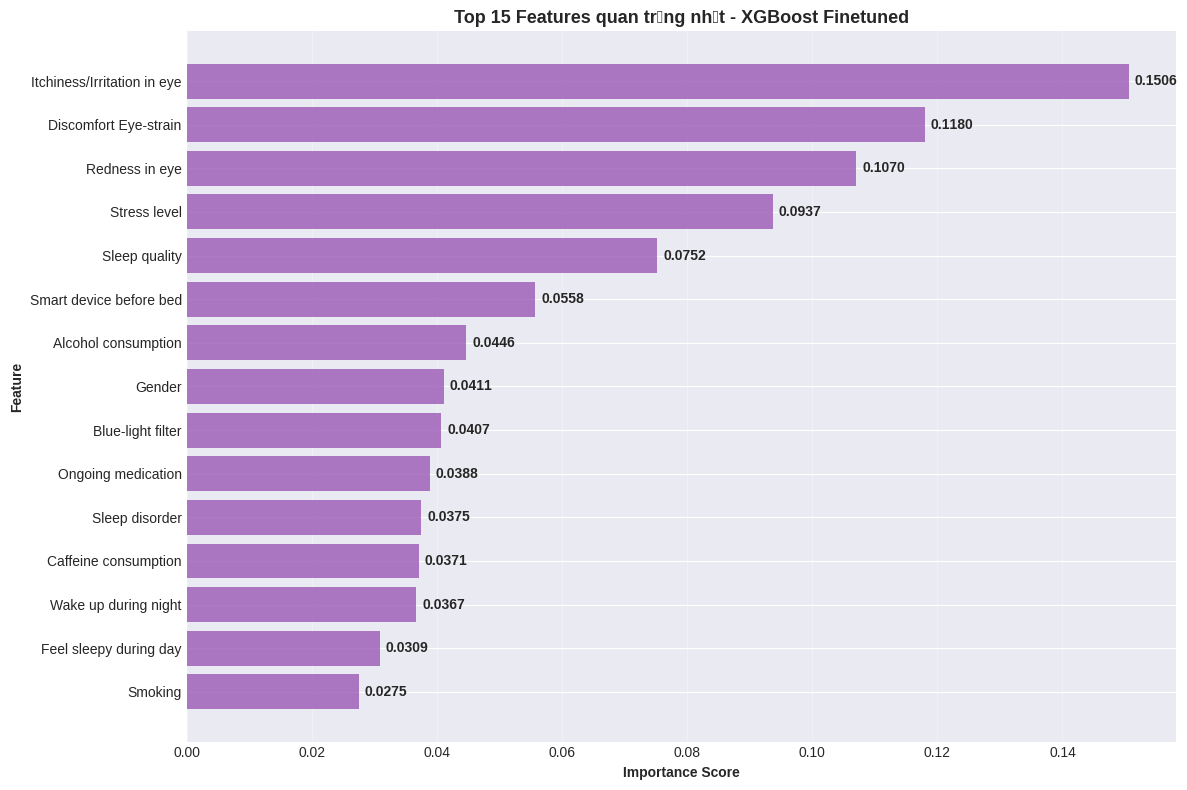

TOP 15 FEATURES QUAN TRỌNG NHẤT:
                    Feature  Importance
Itchiness/Irritation in eye    0.150565
      Discomfort Eye-strain    0.117981
             Redness in eye    0.107050
               Stress level    0.093694
              Sleep quality    0.075207
    Smart device before bed    0.055769
        Alcohol consumption    0.044642
                     Gender    0.041098
          Blue-light filter    0.040667
         Ongoing medication    0.038839
             Sleep disorder    0.037522
       Caffeine consumption    0.037114
       Wake up during night    0.036717
     Feel sleepy during day    0.030870
                    Smoking    0.027517

NHẬN XÉT:
Feature quan trọng nhất: Itchiness/Irritation in eye
Importance score: 0.1506


In [15]:
# Feature Importance của model đã finetune
feature_importance = pd.DataFrame({
    'Feature': refined_features,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Visualize Top features
plt.figure(figsize=(12, 8))
top_n = min(15, len(refined_features))
top_features = feature_importance.head(top_n)

plt.barh(range(top_n), top_features['Importance'], color='#9b59b6', alpha=0.8)
plt.yticks(range(top_n), top_features['Feature'])
plt.xlabel('Importance Score', fontweight='bold')
plt.ylabel('Feature', fontweight='bold')
plt.title(f'Top {top_n} Features quan trọng nhất - XGBoost Finetuned', fontweight='bold', fontsize=13)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Thêm giá trị
for i, v in enumerate(top_features['Importance']):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("="*70)
print(f"TOP {top_n} FEATURES QUAN TRỌNG NHẤT:")
print("="*70)
print(feature_importance.head(top_n).to_string(index=False))

print("\n" + "="*70)
print("NHẬN XÉT:")
print("="*70)
print(f"Feature quan trọng nhất: {top_features.iloc[0]['Feature']}")
print(f"Importance score: {top_features.iloc[0]['Importance']:.4f}")

## 8. Ensemble (nếu cần)

*Phần này có thể thêm các mô hình Ensemble như Voting Classifier, Stacking, hoặc Blending nếu muốn cải thiện thêm hiệu suất*

In [16]:
!pip install lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [17]:
# Import thư viện cho Ensemble
try:
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    from sklearn.ensemble import VotingClassifier
    print("✓ Import thành công: LightGBM, CatBoost, VotingClassifier")
except ImportError:
    print("⚠️ Cần cài đặt: pip install lightgbm catboost")

✓ Import thành công: LightGBM, CatBoost, VotingClassifier


In [18]:
# Train 3 base models
print("="*70)
print("ENSEMBLE - TRAINING BASE MODELS")
print("="*70)

# 1. XGBoost (sử dụng best params từ GridSearchCV)
print("\n1️⃣  XGBoost (với best parameters)...")
xgb_model = XGBClassifier(
    **grid_search.best_params_,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train_refined_resampled, y_train_refined_resampled)
print("   ✓ Trained")

# 2. LightGBM
print("\n2️⃣  LightGBM...")
lgbm_model = LGBMClassifier(
    n_estimators=grid_search.best_params_.get('n_estimators', 100),
    max_depth=grid_search.best_params_.get('max_depth', 5),
    learning_rate=grid_search.best_params_.get('learning_rate', 0.1),
    subsample=grid_search.best_params_.get('subsample', 0.8),
    colsample_bytree=grid_search.best_params_.get('colsample_bytree', 0.8),
    min_child_weight=grid_search.best_params_.get('min_child_weight', 1),
    random_state=42,
    verbose=-1
)
lgbm_model.fit(X_train_refined_resampled, y_train_refined_resampled)
print("   ✓ Trained")

# 3. CatBoost
print("\n3️⃣  CatBoost...")
catboost_model = CatBoostClassifier(
    iterations=grid_search.best_params_.get('n_estimators', 100),
    depth=grid_search.best_params_.get('max_depth', 5),
    learning_rate=grid_search.best_params_.get('learning_rate', 0.1),
    random_state=42,
    verbose=0
)
catboost_model.fit(X_train_refined_resampled, y_train_refined_resampled)
print("   ✓ Trained")

# 4. Voting Classifier (Soft Voting)
print("\n4️⃣  Creating Voting Classifier...")
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft',
    n_jobs=-1
)
voting_clf.fit(X_train_refined_resampled, y_train_refined_resampled)
print("   ✓ Created")

print("\n" + "="*70)
print("✅ ALL MODELS TRAINED!")
print("="*70)

ENSEMBLE - TRAINING BASE MODELS

1️⃣  XGBoost (với best parameters)...
   ✓ Trained

2️⃣  LightGBM...
   ✓ Trained

3️⃣  CatBoost...
   ✓ Trained

4️⃣  Creating Voting Classifier...
   ✓ Created

✅ ALL MODELS TRAINED!


In [19]:
# Đánh giá và so sánh các models
print("="*70)
print("ĐÁNH GIÁ VÀ SO SÁNH")
print("="*70)

models = {
    'XGBoost (Tuned)': xgb_model,
    'LightGBM': lgbm_model,
    'CatBoost': catboost_model,
    'Voting Classifier': voting_clf
}

ensemble_results = []

for name, model in models.items():
    print(f"\n📊 {name}...")
    y_pred = model.predict(X_test_refined_scaled)

    acc = accuracy_score(y_test_refined, y_pred)
    report = classification_report(y_test_refined, y_pred, output_dict=True, zero_division=0)

    ensemble_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score']
    })

    print(f"   Acc: {acc:.4f} | Prec: {report['1']['precision']:.4f} | "
          f"Rec: {report['1']['recall']:.4f} | F1: {report['1']['f1-score']:.4f}")

ensemble_results_df = pd.DataFrame(ensemble_results)

print("\n" + "="*70)
print("TỔNG HỢP:")
print("="*70)
print(ensemble_results_df.to_string(index=False))

# Tìm best model
best_idx = ensemble_results_df['F1-Score'].idxmax()
best_model_name = ensemble_results_df.loc[best_idx, 'Model']
best_f1 = ensemble_results_df.loc[best_idx, 'F1-Score']

print(f"\n🏆 BEST: {best_model_name} (F1={best_f1:.4f})")

ĐÁNH GIÁ VÀ SO SÁNH

📊 XGBoost (Tuned)...
   Acc: 0.7003 | Prec: 0.7021 | Rec: 0.9382 | F1: 0.8032

📊 LightGBM...
   Acc: 0.7000 | Prec: 0.7019 | Rec: 0.9382 | F1: 0.8030

📊 CatBoost...
   Acc: 0.7003 | Prec: 0.7021 | Rec: 0.9382 | F1: 0.8032

📊 Voting Classifier...
   Acc: 0.7003 | Prec: 0.7021 | Rec: 0.9382 | F1: 0.8032

TỔNG HỢP:
            Model  Accuracy  Precision   Recall  F1-Score
  XGBoost (Tuned)   0.70025   0.702067 0.938243  0.803152
         LightGBM   0.70000   0.701865 0.938243  0.803020
         CatBoost   0.70025   0.702067 0.938243  0.803152
Voting Classifier   0.70025   0.702067 0.938243  0.803152

🏆 BEST: XGBoost (Tuned) (F1=0.8032)


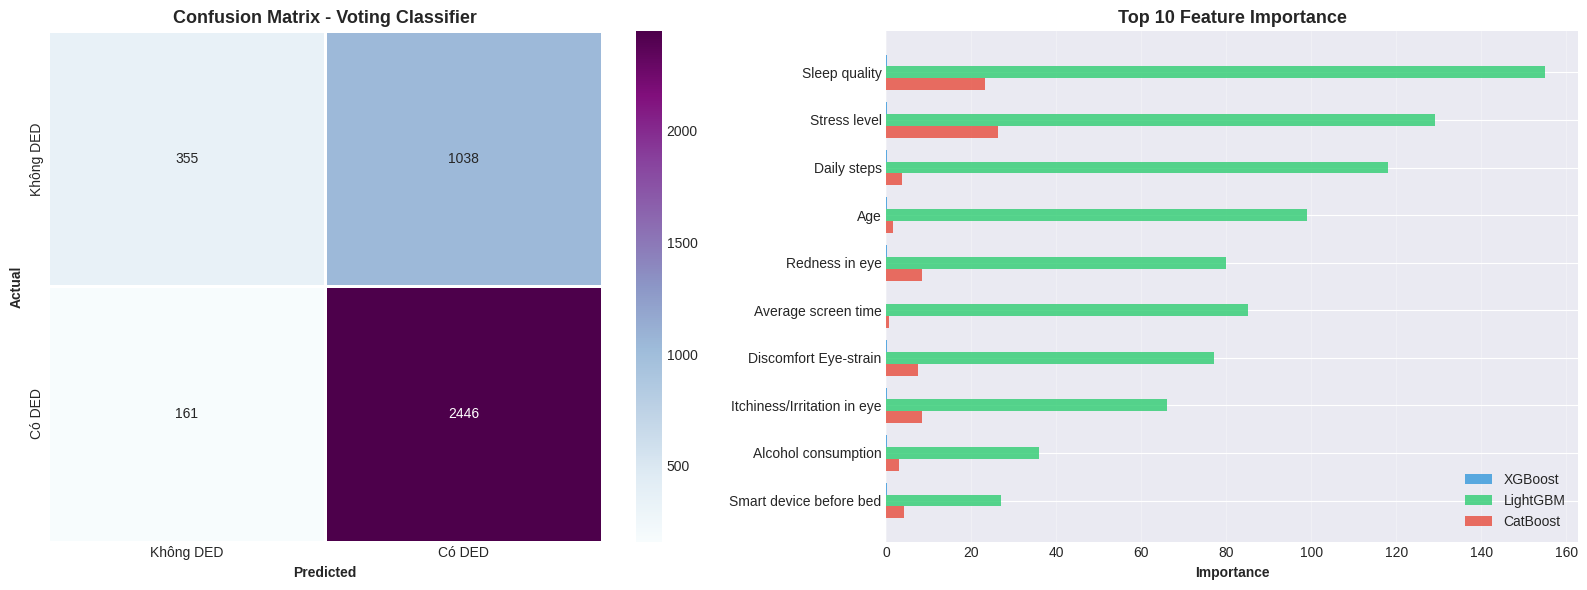


Top 10 Features (Average):
                    Feature   Average
              Sleep quality 59.409494
               Stress level 51.756635
                Daily steps 40.597439
                        Age 33.522132
             Redness in eye 29.469070
        Average screen time 28.498563
      Discomfort Eye-strain 28.148348
Itchiness/Irritation in eye 24.819853
        Alcohol consumption 13.002291
    Smart device before bed 10.415244


In [20]:
# Confusion Matrix & Feature Importance
y_pred_voting = voting_clf.predict(X_test_refined_scaled)
cm_voting = confusion_matrix(y_test_refined, y_pred_voting)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='BuPu',
            xticklabels=['Không DED', 'Có DED'],
            yticklabels=['Không DED', 'Có DED'],
            ax=axes[0], linewidths=1)
axes[0].set_title('Confusion Matrix - Voting Classifier', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Actual', fontweight='bold')
axes[0].set_xlabel('Predicted', fontweight='bold')

# Feature Importance (average)
xgb_imp = xgb_model.feature_importances_
lgbm_imp = lgbm_model.feature_importances_
catboost_imp = catboost_model.feature_importances_
avg_imp = (xgb_imp + lgbm_imp + catboost_imp) / 3

importance_df = pd.DataFrame({
    'Feature': refined_features,
    'XGBoost': xgb_imp,
    'LightGBM': lgbm_imp,
    'CatBoost': catboost_imp,
    'Average': avg_imp
}).sort_values('Average', ascending=False)

# Plot top 10
top_10 = importance_df.head(10)
x = np.arange(len(top_10))
w = 0.25

axes[1].barh(x - w, top_10['XGBoost'], w, label='XGBoost', alpha=0.8, color='#3498db')
axes[1].barh(x, top_10['LightGBM'], w, label='LightGBM', alpha=0.8, color='#2ecc71')
axes[1].barh(x + w, top_10['CatBoost'], w, label='CatBoost', alpha=0.8, color='#e74c3c')

axes[1].set_yticks(x)
axes[1].set_yticklabels(top_10['Feature'])
axes[1].invert_yaxis()
axes[1].set_xlabel('Importance', fontweight='bold')
axes[1].set_title('Top 10 Feature Importance', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Features (Average):")
print(importance_df[['Feature', 'Average']].head(10).to_string(index=False))

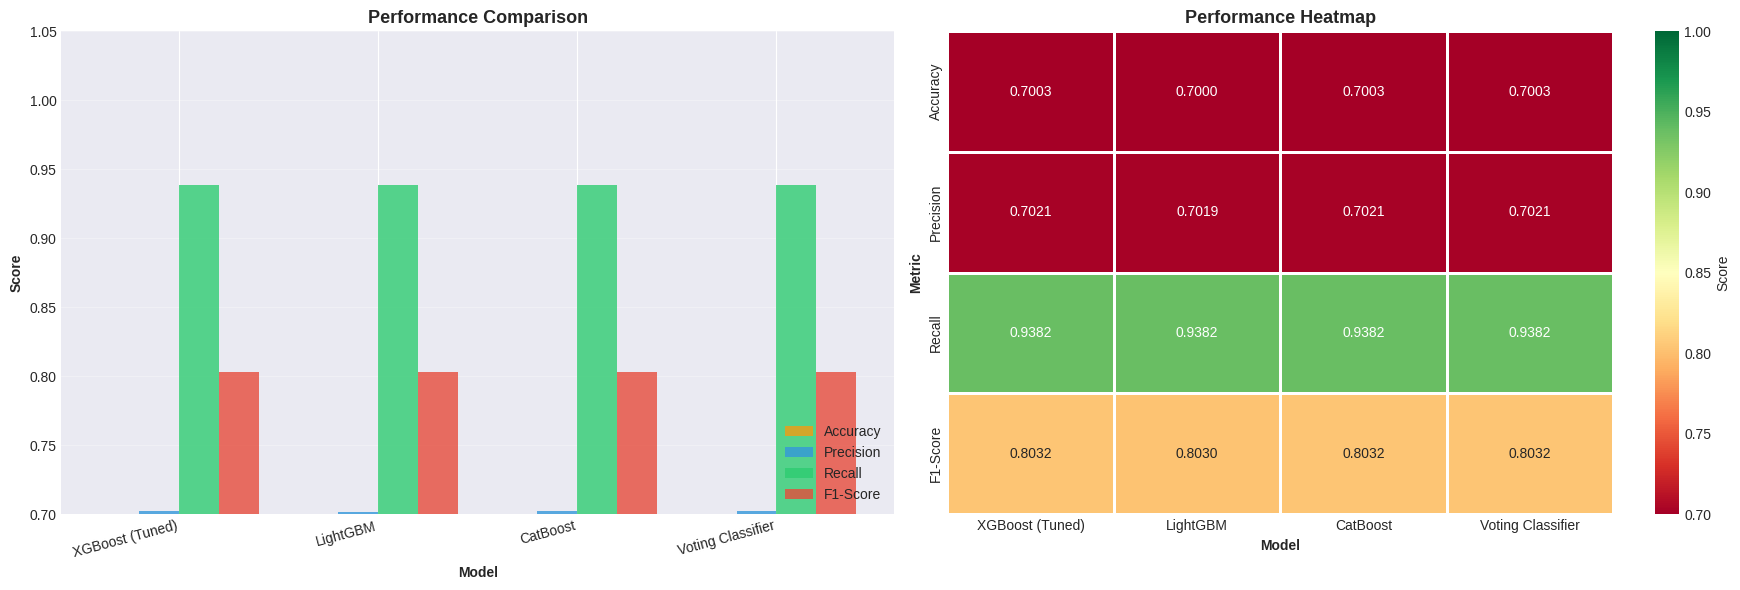

In [21]:
# Visualize so sánh
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
ax1 = axes[0]
x = np.arange(len(ensemble_results_df))
width = 0.2

ax1.bar(x - 1.5*width, ensemble_results_df['Accuracy'], width, label='Accuracy', color='#f39c12', alpha=0.8)
ax1.bar(x - 0.5*width, ensemble_results_df['Precision'], width, label='Precision', color='#3498db', alpha=0.8)
ax1.bar(x + 0.5*width, ensemble_results_df['Recall'], width, label='Recall', color='#2ecc71', alpha=0.8)
ax1.bar(x + 1.5*width, ensemble_results_df['F1-Score'], width, label='F1-Score', color='#e74c3c', alpha=0.8)

ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Performance Comparison', fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(ensemble_results_df['Model'], rotation=15, ha='right')
ax1.legend(loc='lower right')
ax1.set_ylim([0.7, 1.05])
ax1.grid(axis='y', alpha=0.3)

# Heatmap
ax2 = axes[1]
heatmap_data = ensemble_results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']].T
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='RdYlGn',
           vmin=0.7, vmax=1.0, ax=ax2, cbar_kws={'label': 'Score'}, linewidths=1)
ax2.set_title('Performance Heatmap', fontweight='bold', fontsize=13)
ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Metric', fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Stacking Ensemble với Neural Network Meta-learner

Kết hợp nhiều boosting models (XGBoost, LightGBM, CatBoost, GradientBoosting, HistGradientBoosting) với Neural Network để tăng accuracy và cân bằng recall

In [3]:
!pip install tensorflow catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [1]:
best_params = {
        "colsample_bytree": 0.9,
        "gamma": 0,
        "learning_rate": 0.1,
        "max_depth": 3,
        "min_child_weight": 1,
        "n_estimators": 150,
        "subsample": 0.8
    }

STACKING ENSEMBLE - NEURAL NETWORK META-LEARNER
✓ Đã import TensorFlow/Keras
✓ Đã import LightGBM
✓ Đã import CatBoost

1. Chuẩn bị data cho stacking ensemble...
   ✓ Data shape: (20000, 19)
   ✓ Features: 19

2. Khởi tạo base models...
   ✓ XGBoost (with best params)
   ✓ LightGBM
   ✓ CatBoost
   ✓ Gradient Boosting
   ✓ Histogram Gradient Boosting

   Tổng số base models: 5

3. K-Fold Cross Validation (5 folds)...

   Fold 1/5:
      XGBoost: 0.7037
      LightGBM: 0.7025
      CatBoost: 0.7015
      GradientBoosting: 0.7037
      HistGradientBoosting: 0.6995

   Fold 2/5:
      XGBoost: 0.6870
      LightGBM: 0.6850
      CatBoost: 0.6810
      GradientBoosting: 0.6875
      HistGradientBoosting: 0.6837

   Fold 3/5:
      XGBoost: 0.6957
      LightGBM: 0.6927
      CatBoost: 0.6887
      GradientBoosting: 0.6957
      HistGradientBoosting: 0.6933

   Fold 4/5:
      XGBoost: 0.7017
      LightGBM: 0.7010
      CatBoost: 0.6990
      GradientBoosting: 0.7027
      HistGradientBoos

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,409 (193.00 KB)

 Trainable params: 48,513 (189.50 KB)

 Non-trainable params: 896 (3.50 KB)


7. Training Neural Network...
Epoch 1/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5956 - loss: 0.7261 - val_accuracy: 0.2382 - val_loss: 0.9480 - learning_rate: 0.0010
Epoch 2/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6604 - loss: 0.6443 - val_accuracy: 0.2426 - val_loss: 0.9458 - learning_rate: 0.0010
Epoch 3/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6713 - loss: 0.6311 - val_accuracy: 0.2376 - val_loss: 0.9322 - learning_rate: 0.0010
Epoch 4/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6785 - loss: 0.6298 - val_accuracy: 0.2374 - val_loss: 0.9015 - learning_rate: 0.0010
Epoch 5/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6780 - loss: 0.6254 - val_accuracy: 0.2407 - val_loss: 0.9037 - learning_rate: 0.0010
Epoch 6/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6806 - loss: 0.6244 - val_accuracy: 0.2362 - val_loss: 0.9230 - learning_rate: 0.0010
Epoch 7/100
652/652 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/ste

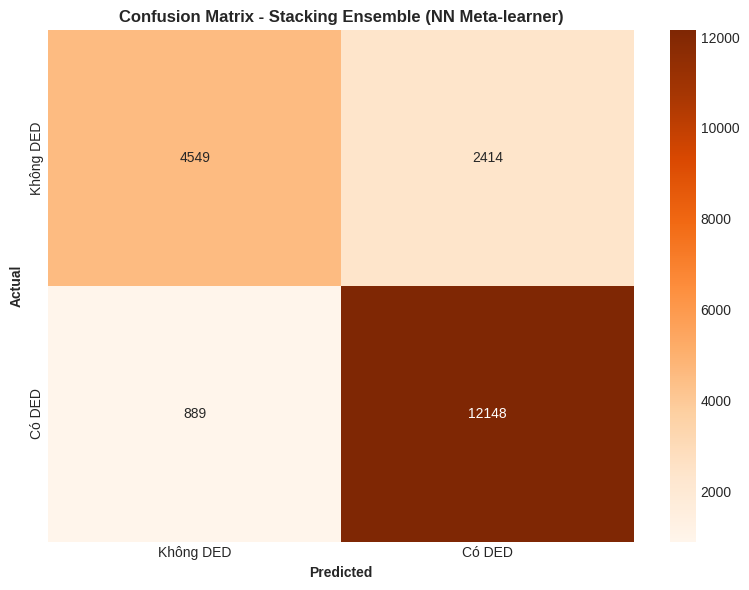


9. Visualize Training History...


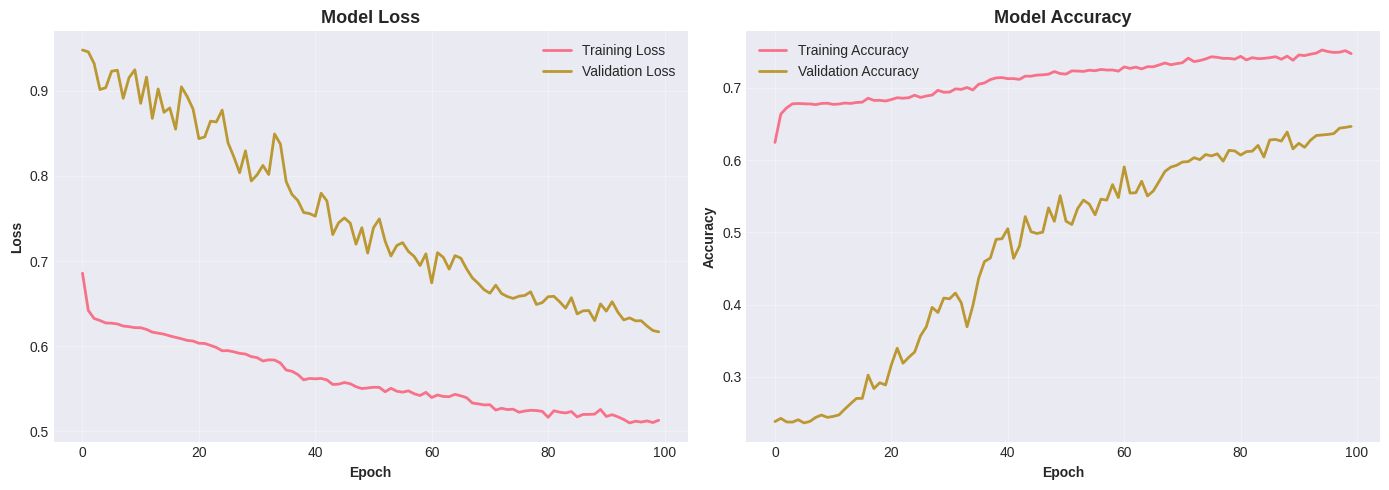


NHẬN XÉT:
 Stacking Ensemble đạt mục tiêu:
   • Recall Không DED: 0.6533 > 0.50
   • Recall Có DED: 0.9318 > 0.80



In [23]:
# Stacking Ensemble với Neural Network Meta-learner
print("="*80)
print("STACKING ENSEMBLE - NEURAL NETWORK META-LEARNER")
print("="*80)

# Import thêm thư viện cần thiết
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    print("✓ Đã import TensorFlow/Keras")
except ImportError:
    print("ERROR: TensorFlow chưa được cài đặt!")
    print("Chạy: pip install tensorflow")
    raise

try:
    from lightgbm import LGBMClassifier
    print("✓ Đã import LightGBM")
    use_lgbm = True
except ImportError:
    print("⚠ LightGBM không có, bỏ qua")
    use_lgbm = False

try:
    from catboost import CatBoostClassifier
    print("✓ Đã import CatBoost")
    use_catboost = True
except ImportError:
    print("⚠ CatBoost không có, bỏ qua")
    use_catboost = False

from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler

print("\n1. Chuẩn bị data cho stacking ensemble...")
# Sử dụng refined features và data đã split từ trước
X_full = df_clean[refined_features]
y_full = df_clean[target]

print(f"   ✓ Data shape: {X_full.shape}")
print(f"   ✓ Features: {len(refined_features)}")

# Define boosting models (base learners)
print("\n2. Khởi tạo base models...")
base_models = []
base_model_names = []

# XGBoost (sử dụng best params đã tune)
xgb_stacking = XGBClassifier(**best_params, random_state=42, eval_metric='logloss')
base_models.append(xgb_stacking)
base_model_names.append('XGBoost')
print("   ✓ XGBoost (with best params)")

# LightGBM
if use_lgbm:
    lgbm = LGBMClassifier(random_state=42, verbose=-1)
    base_models.append(lgbm)
    base_model_names.append('LightGBM')
    print("   ✓ LightGBM")

# CatBoost
if use_catboost:
    catboost = CatBoostClassifier(verbose=0, random_state=42)
    base_models.append(catboost)
    base_model_names.append('CatBoost')
    print("   ✓ CatBoost")

# Gradient Boosting
gbm = GradientBoostingClassifier(random_state=42)
base_models.append(gbm)
base_model_names.append('GradientBoosting')
print("   ✓ Gradient Boosting")

# Histogram-based Gradient Boosting
hist_gbm = HistGradientBoostingClassifier(random_state=42)
base_models.append(hist_gbm)
base_model_names.append('HistGradientBoosting')
print("   ✓ Histogram Gradient Boosting")

print(f"\n   Tổng số base models: {len(base_models)}")

# K-Fold Cross Validation để tạo OOF predictions
print("\n3. K-Fold Cross Validation (5 folds)...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create empty arrays for OOF predictions
oof_predictions = {name: np.zeros(len(y_full)) for name in base_model_names}

# Scaling toàn bộ data
scaler_stacking = StandardScaler()
X_full_scaled = scaler_stacking.fit_transform(X_full)

fold = 1
for train_idx, val_idx in kf.split(X_full_scaled, y_full):
    print(f"\n   Fold {fold}/5:")
    X_train_fold, X_val_fold = X_full_scaled[train_idx], X_full_scaled[val_idx]
    y_train_fold, y_val_fold = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # SMOTE cho training data
    smote = SMOTE(random_state=42, sampling_strategy=0.7)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    # Train từng base model
    for idx, (model, name) in enumerate(zip(base_models, base_model_names)):
        model.fit(X_train_resampled, y_train_resampled)

        # Lưu OOF predictions (probability của class 1)
        oof_predictions[name][val_idx] = model.predict_proba(X_val_fold)[:, 1]

        # Calculate fold accuracy
        fold_pred = (model.predict_proba(X_val_fold)[:, 1] > 0.5).astype(int)
        fold_acc = accuracy_score(y_val_fold, fold_pred)
        print(f"      {name}: {fold_acc:.4f}")

    fold += 1

print("\n   ✓ Hoàn tất K-Fold CV!")

# Concatenate OOF predictions với original features
print("\n4. Tạo features cho Neural Network meta-learner...")
oof_array = np.column_stack([oof_predictions[name] for name in base_model_names])
X_nn = np.column_stack((X_full_scaled, oof_array))

print(f"   ✓ Original features: {X_full_scaled.shape[1]}")
print(f"   ✓ OOF predictions: {oof_array.shape[1]}")
print(f"   ✓ Total features for NN: {X_nn.shape[1]}")

# Apply RandomOverSampler cho final NN model training
print("\n5. Apply RandomOverSampler...")
ros = RandomOverSampler(random_state=42)
X_nn_resampled, y_resampled = ros.fit_resample(X_nn, y_full)
print(f"   ✓ Before: {len(y_full)} samples")
print(f"   ✓ After: {len(y_resampled)} samples")
print(f"   ✓ Class distribution: {pd.Series(y_resampled).value_counts().to_dict()}")

# Define Neural Network meta-learner
print("\n6. Định nghĩa Neural Network architecture...")
def create_nn_model(input_dim):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.1),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

nn_model = create_nn_model(X_nn.shape[1])
print("   ✓ NN Model architecture:")
nn_model.summary()

# Define callbacks
print("\n7. Training Neural Network...")
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train Neural Network
history = nn_model.fit(
    X_nn_resampled, y_resampled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)

print("\n✓ Training completed!")

# Evaluate trên toàn bộ data (để so sánh với OOF)
print("\n8. Đánh giá model...")
final_pred_proba = nn_model.predict(X_nn).flatten()
final_pred = (final_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_full, final_pred)
precision = precision_score(y_full, final_pred, zero_division=0)
recall = recall_score(y_full, final_pred, zero_division=0)
f1_macro = f1_score(y_full, final_pred, average='macro')

# Tính recall cho từng class
recall_0 = recall_score(y_full, final_pred, pos_label=0, zero_division=0)
recall_1 = recall_score(y_full, final_pred, pos_label=1, zero_division=0)

print("\n" + "="*80)
print("KẾT QUẢ STACKING ENSEMBLE - NEURAL NETWORK META-LEARNER")
print("="*80)
print(f"\nOverall Metrics:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Macro:  {f1_macro:.4f}")

print(f"\nRecall per class:")
print(f"  Recall (Không DED): {recall_0:.4f}")
print(f"  Recall (Có DED):    {recall_1:.4f}")

# Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_full, final_pred, target_names=['Không DED', 'Có DED']))

# Confusion Matrix
cm_stacking = confusion_matrix(y_full, final_pred)
print("\nConfusion Matrix:")
print(cm_stacking)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_stacking, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Không DED', 'Có DED'],
            yticklabels=['Không DED', 'Có DED'])
plt.title('Confusion Matrix - Stacking Ensemble (NN Meta-learner)',
          fontweight='bold', fontsize=12)
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.tight_layout()
plt.show()

# Visualize training history
print("\n9. Visualize Training History...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontweight='bold')
axes[0].set_ylabel('Loss', fontweight='bold')
axes[0].set_title('Model Loss', fontweight='bold', fontsize=13)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontweight='bold')
axes[1].set_ylabel('Accuracy', fontweight='bold')
axes[1].set_title('Model Accuracy', fontweight='bold', fontsize=13)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("NHẬN XÉT:")
print("="*80)
if recall_0 > 0.50 and recall_1 > 0.80:
    print(" Stacking Ensemble đạt mục tiêu:")
    print(f"   • Recall Không DED: {recall_0:.4f} > 0.50")
    print(f"   • Recall Có DED: {recall_1:.4f} > 0.80")
elif recall_0 > 0.50:
    print(" Recall Không DED đã cải thiện tốt")
    print(f"   • Recall Không DED: {recall_0:.4f} > 0.50")
    print(f"   • Recall Có DED: {recall_1:.4f} (hơi thấp)")
else:
    print(" Cần điều chỉnh thêm threshold hoặc architecture")
    print(f"   • Recall Không DED: {recall_0:.4f}")
    print(f"   • Recall Có DED: {recall_1:.4f}")

print("\n" + "="*80)

In [41]:
import os
# Lưu CONFIGURATION để có thể TRAIN LẠI model với cùng tham số
print("\n" + "="*80)
print("LƯU TRAINING CONFIGURATION ĐỂ RETRAIN")
print("="*80)

# Load best XGBoost params
with open('best_xgboost_params.json', 'r') as f:
    best_xgb_params = json.load(f)['best_parameters']

# Tạo training config
training_config = {
    # Dataset info
    "dataset": {
        "file": "Dry_Eye_Dataset.csv",
        "target_column": "Dry_Eye_Disease",
        "target_mapping": {"Không DED": 0, "Có DED": 1}
    },

    # Features
    "features": {
        "refined_features": refined_features,
        "n_features": len(refined_features)
    },

    # Preprocessing
    "preprocessing": {
        "blood_pressure_split": {
            "source_column": "Blood pressure",
            "new_columns": ["Systolic_BP", "Diastolic_BP"],
            "method": "split by /"
        },
        "yn_encoding": {
            "columns": [
                "Smart device before bed", "Blue-light filter", "Sleep disorder",
                "Wake up during night", "Feel sleepy during day", "Medical issue",
                "Ongoing medication", "Smoking", "Alcohol consumption",
                "Caffeine consumption"
            ],
            "mapping": {"Y": 1, "N": 0}
        },
        "gender_encoding": {
            "column": "Gender",
            "mapping": {"Male": 1, "Female": 0}
        }
    },

    # Base models hyperparameters
    "base_models": {
        "xgboost": {
            "max_depth": best_xgb_params.get('max_depth', 3),
            "n_estimators": best_xgb_params.get('n_estimators', 150),
            "learning_rate": best_xgb_params.get('learning_rate', 0.1),
            "subsample": best_xgb_params.get('subsample', 0.8),
            "colsample_bytree": best_xgb_params.get('colsample_bytree', 0.9),
            "random_state": 42,
            "eval_metric": "logloss"
        },
        "lightgbm": {
            "n_estimators": 150,
            "max_depth": 5,
            "learning_rate": 0.1,
            "num_leaves": 31,
            "random_state": 42,
            "verbose": -1
        },
        "catboost": {
            "iterations": 150,
            "depth": 5,
            "learning_rate": 0.1,
            "random_state": 42,
            "verbose": False
        },
        "gradientboosting": {
            "n_estimators": 150,
            "max_depth": 5,
            "learning_rate": 0.1,
            "random_state": 42
        },
        "histgradientboosting": {
            "max_iter": 150,
            "max_depth": 5,
            "learning_rate": 0.1,
            "random_state": 42
        }
    },

    # Neural Network architecture
    "neural_network": {
        "architecture": {
            "layers": [256, 128, 64, 1],
            "activations": ["relu", "relu", "relu", "sigmoid"],
            "dropout_rates": [0.3, 0.2, 0.1, 0.0],
            "batch_normalization": [True, True, True, False]
        },
        "optimizer": {
            "type": "Adam",
            "learning_rate": 0.001
        },
        "loss": "binary_crossentropy",
        "metrics": ["accuracy"],
        "training": {
            "epochs": 100,
            "batch_size": 32,
            "validation_split": 0.2
        },
        "callbacks": {
            "early_stopping": {
                "monitor": "val_loss",
                "patience": 20,
                "restore_best_weights": True
            },
            "reduce_lr": {
                "monitor": "val_loss",
                "factor": 0.5,
                "patience": 10,
                "min_lr": 0.00001
            }
        }
    },

    # Training strategy
    "training_strategy": {
        "k_folds": 5,
        "smote_for_base_models": {
            "enabled": True,
            "sampling_strategy": 0.7
        },
        "oversampling_for_nn": {
            "method": "RandomOverSampler",
            "enabled": True
        },
        "random_seed": 42
    },

    # Performance achieved
    "performance_reference": {
        "accuracy": float(accuracy),
        "precision": float(precision),
        "recall": float(recall),
        "f1_macro": float(f1_macro),
        "recall_class_0": float(recall_0),
        "recall_class_1": float(recall_1)
    },

    # Metadata
    "metadata": {
        "created_at": pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        "model_type": "Stacking Ensemble with Neural Network Meta-learner",
        "base_models_count": 5,
        "total_nn_input_features": X_nn.shape[1]
    }
}

# Lưu config
config_path = os.path.join("/content/drive/MyDrive", 'training_config.json')
with open(config_path, 'w', encoding='utf-8') as f:
    json.dump(training_config, f, indent=4, ensure_ascii=False)

print(f"\nĐã lưu training configuration: {config_path}")
print(f"\nFile này chứa:")
print("  1. Dataset info & preprocessing steps")
print("  2. 19 refined features list")
print("  3. Hyperparameters của 5 base models")
print("  4. Neural Network architecture & training config")
print("  5. K-Fold, SMOTE, oversampling strategy")
print("  6. Performance reference")

print("\nSử dụng file này để:")
print("   → Retrain model với CÙNG tham số")
print("   → Reproduce lại kết quả")
print("   → Document cho team/production")

print("\n" + "="*80)


LƯU TRAINING CONFIGURATION ĐỂ RETRAIN

Đã lưu training configuration: /content/drive/MyDrive/training_config.json

File này chứa:
  1. Dataset info & preprocessing steps
  2. 19 refined features list
  3. Hyperparameters của 5 base models
  4. Neural Network architecture & training config
  5. K-Fold, SMOTE, oversampling strategy
  6. Performance reference

Sử dụng file này để:
   → Retrain model với CÙNG tham số
   → Reproduce lại kết quả
   → Document cho team/production




PREDICTION FLOW VISUALIZATION


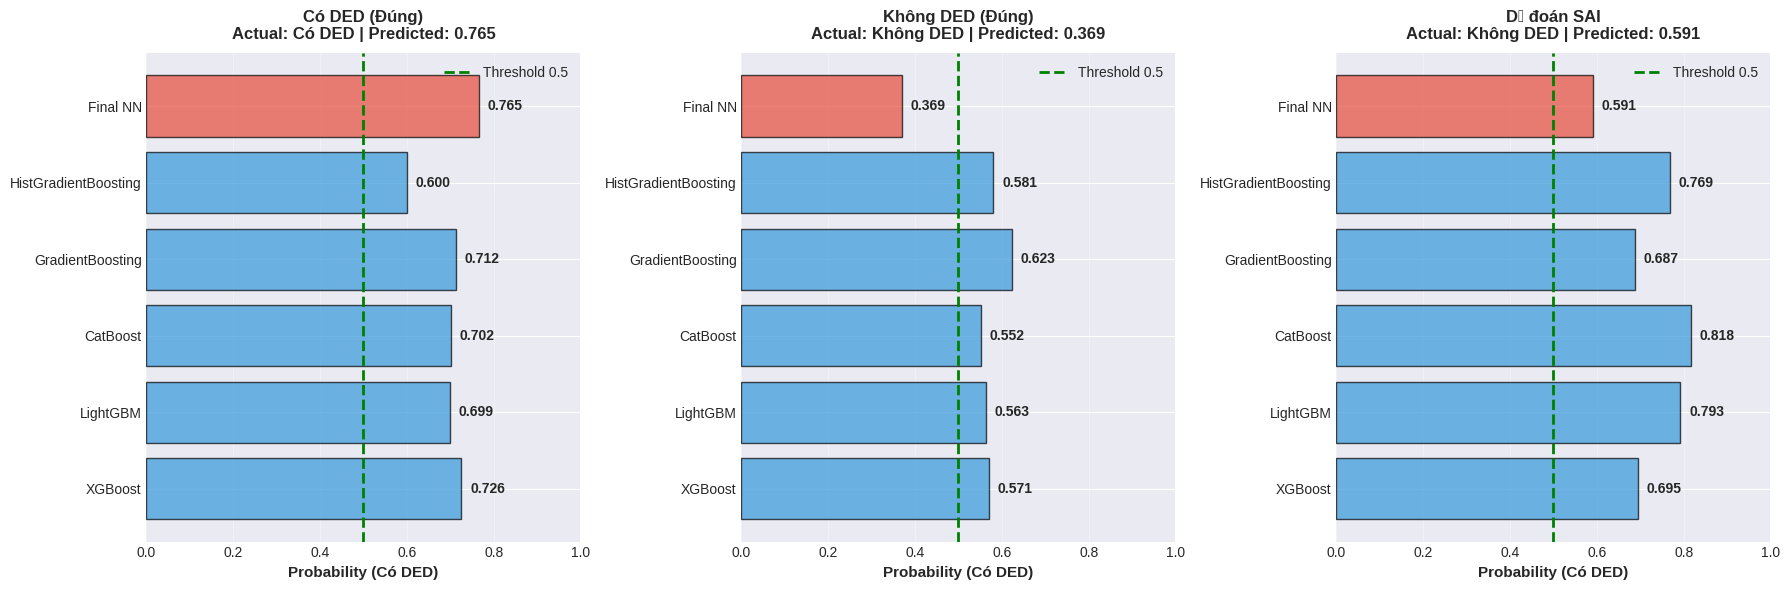


Giải thích:
  • 5 thanh đầu: Dự đoán từ 5 base models (XGBoost, LightGBM, CatBoost, GB, HistGB)
  • Thanh cuối (đỏ): Dự đoán cuối cùng từ Neural Network meta-learner
  • NN học cách kết hợp 5 base predictions + original features → final decision


In [24]:
# Visualize Prediction Flow: Features → Base Models → Neural Network → Final
print("\n" + "="*80)
print("PREDICTION FLOW VISUALIZATION")
print("="*80)

# Chọn 3 samples để phân tích: 1 Có DED đúng, 1 Không DED đúng, 1 sai
correct_ded = np.where((y_full == 1) & (final_pred == 1))[0][0]
correct_khong_ded = np.where((y_full == 0) & (final_pred == 0))[0][0]
wrong_pred = np.where(y_full != final_pred)[0][0] if len(np.where(y_full != final_pred)[0]) > 0 else correct_ded

samples_to_analyze = [
    (correct_ded, "Có DED (Đúng)"),
    (correct_khong_ded, "Không DED (Đúng)"),
    (wrong_pred, "Dự đoán SAI")
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (sample_idx, title) in enumerate(samples_to_analyze):
    ax = axes[idx]

    # Lấy predictions từ 5 base models (oof_predictions là dictionary)
    base_preds = [oof_predictions[name][sample_idx] for name in base_model_names]

    # Final prediction
    final_pred_val = final_pred_proba[sample_idx]
    actual = y_full.iloc[sample_idx]

    # Visualize
    models_extended = base_model_names + ['Final NN']
    values = list(base_preds) + [final_pred_val]
    colors_list = ['#3498db']*5 + ['#e74c3c']

    bars = ax.barh(models_extended, values, color=colors_list, alpha=0.7, edgecolor='black')

    # Threshold line
    ax.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Threshold 0.5')

    # Annotations
    for i, (model, val) in enumerate(zip(models_extended, values)):
        ax.text(val + 0.02, i, f'{val:.3f}', va='center', fontsize=10, fontweight='bold')

    ax.set_xlabel('Probability (Có DED)', fontsize=11, fontweight='bold')
    ax.set_title(f'{title}\nActual: {"Có DED" if actual==1 else "Không DED"} | Predicted: {final_pred_val:.3f}',
                 fontsize=12, fontweight='bold', pad=10)
    ax.set_xlim(0, 1)
    ax.legend()
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGiải thích:")
print("  • 5 thanh đầu: Dự đoán từ 5 base models (XGBoost, LightGBM, CatBoost, GB, HistGB)")
print("  • Thanh cuối (đỏ): Dự đoán cuối cùng từ Neural Network meta-learner")
print("  • NN học cách kết hợp 5 base predictions + original features → final decision")

### 7. SHAP Decision Plot - Visualize quá trình ra quyết định

Giải thích bằng base là XGBoost

In [25]:
!pip install SHAP -q

1. SHAP SUMMARY PLOT - Tổng quan ảnh hưởng của features


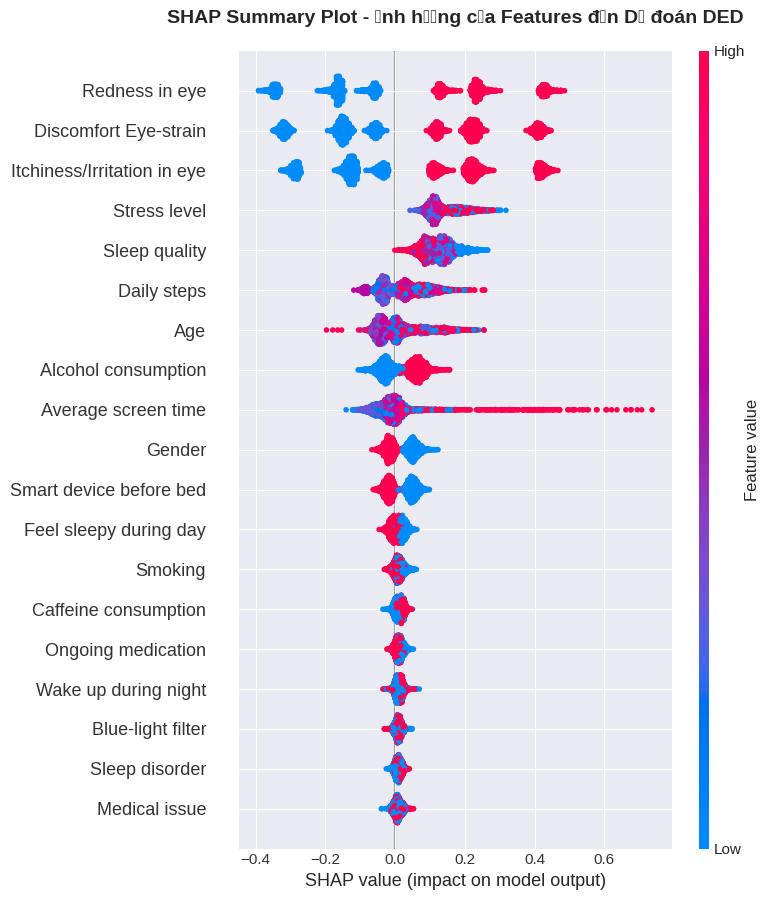


Giải thích Summary Plot:
  • Trục Y: Features được xếp theo mức độ quan trọng (từ cao đến thấp)
  • Trục X: SHAP value (ảnh hưởng đến dự đoán)
    - Giá trị dương → Tăng xác suất mắc DED
    - Giá trị âm → Giảm xác suất mắc DED
  • Màu sắc: Giá trị của feature
    - Đỏ: Giá trị cao
    - Xanh dương: Giá trị thấp


In [42]:
# SHAP Summary Plot (Beeswarm plot)
print("="*70)
print("1. SHAP SUMMARY PLOT - Tổng quan ảnh hưởng của features")
print("="*70)

plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_refined_scaled, feature_names=refined_features, show=False)
plt.title('SHAP Summary Plot - Ảnh hưởng của Features đến Dự đoán DED',
          fontweight='bold', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

print("\nGiải thích Summary Plot:")
print("  • Trục Y: Features được xếp theo mức độ quan trọng (từ cao đến thấp)")
print("  • Trục X: SHAP value (ảnh hưởng đến dự đoán)")
print("    - Giá trị dương → Tăng xác suất mắc DED")
print("    - Giá trị âm → Giảm xác suất mắc DED")
print("  • Màu sắc: Giá trị của feature")
print("    - Đỏ: Giá trị cao")
print("    - Xanh dương: Giá trị thấp")